In [ ]:
!pip -q uninstall -y torch torchvision torchaudio
!pip -q install --no-cache-dir torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 114.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 167.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 166.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 183.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 121.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 159.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 120.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 135.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE = "/content/drive/MyDrive/NEGIL"
CHEX = os.path.join(BASE, "CheXpert")
OUT  = os.path.join(BASE, "Negil_Thesis_OUTPUTS")
os.makedirs(OUT, exist_ok=True)

print("CHEX:", CHEX, "exists:", os.path.exists(CHEX))
print("OUT :", OUT,  "exists:", os.path.exists(OUT))
print("CHEX contents:", os.listdir(CHEX))


Mounted at /content/drive
CHEX: /content/drive/MyDrive/NEGIL/CheXpert exists: True
OUT : /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS exists: True
CHEX contents: ['train.csv', 'valid.csv', 'valid', 'train']


In [ ]:
!pip -q install pandas numpy scikit-learn matplotlib tqdm pillow
!pip -q install torch torchvision

import torch
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA: False


**Load CSVs + Build abs paths (Checkpoint 3)**

In [ ]:
import pandas as pd

df_train = pd.read_csv(os.path.join(CHEX, "train.csv"))
df_valid = pd.read_csv(os.path.join(CHEX, "valid.csv"))

path_col = "Path" if "Path" in df_train.columns else [c for c in df_train.columns if "path" in c.lower()][0]
print("Using path column:", path_col)

def make_abs(p):
    p = str(p).replace("CheXpert-v1.0-small/", "", 1)
    return os.path.join(CHEX, p)

df_train["abs_path"] = df_train[path_col].apply(make_abs)
df_valid["abs_path"] = df_valid[path_col].apply(make_abs)

# quick sanity
import os
print(df_train["abs_path"].head(3).tolist())
print("Train exists rate (200):", df_train["abs_path"].head(200).apply(os.path.exists).mean())
print("Valid exists rate (200):", df_valid["abs_path"].head(200).apply(os.path.exists).mean())


Using path column: Path
['/content/drive/MyDrive/NEGIL/CheXpert/train/patient00001/study1/view1_frontal.jpg', '/content/drive/MyDrive/NEGIL/CheXpert/train/patient00002/study2/view1_frontal.jpg', '/content/drive/MyDrive/NEGIL/CheXpert/train/patient00002/study1/view1_frontal.jpg']
Train exists rate (200): 0.995
Valid exists rate (200): 1.0


**Cell 4 — Labels (locked MSc-safe 6 labels) (Checkpoint 4)**

In [ ]:
preferred = ["No Finding", "Pneumonia", "Edema", "Pleural Effusion", "Cardiomegaly", "Atelectasis"]
label_cols = [c for c in preferred if c in df_train.columns]
print("Using labels:", label_cols)
assert len(label_cols) == 6, "Expected 6 labels. Paste your train columns list if this fails."


Using labels: ['No Finding', 'Pneumonia', 'Edema', 'Pleural Effusion', 'Cardiomegaly', 'Atelectasis']


In [ ]:
import shutil
from tqdm import tqdm
import os

LOCAL_CACHE = "/content/chex_cache"
TRAIN_CACHE = os.path.join(LOCAL_CACHE, "train")
VALID_CACHE = os.path.join(LOCAL_CACHE, "valid")
os.makedirs(TRAIN_CACHE, exist_ok=True)
os.makedirs(VALID_CACHE, exist_ok=True)

N_TRAIN = min(12000, len(df_train))
N_VALID = min(3000, len(df_valid))

df_train_sub = df_train.sample(n=N_TRAIN, random_state=42).copy()
df_valid_sub = df_valid.sample(n=N_VALID, random_state=42).copy()

def cache_files(df, dst_dir):
    out_paths = []
    for p in tqdm(df["abs_path"].tolist(), desc=f"Caching to {dst_dir}"):
        fname = os.path.basename(p)
        outp = os.path.join(dst_dir, fname)
        if not os.path.exists(outp):
            shutil.copy2(p, outp)
        out_paths.append(outp)
    return out_paths

df_train_sub["abs_local"] = cache_files(df_train_sub, TRAIN_CACHE)
df_valid_sub["abs_local"] = cache_files(df_valid_sub, VALID_CACHE)

print("Cached:", len(df_train_sub), "train |", len(df_valid_sub), "valid")
print("Example cached file exists:", os.path.exists(df_train_sub["abs_local"].iloc[0]))


Caching to /content/chex_cache/valid: 100%|██████████| 234/234 [00:03<00:00, 72.06it/s]

Cached: 12000 train | 234 valid
Example cached file exists: True


**Cell 6 — Build fast Dataset + DataLoader (Checkpoint 6)**

In [ ]:
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

transform = T.Compose([T.Resize((224,224)), T.ToTensor()])

# pre-cast labels once (no warning spam + faster)
train_y = df_train_sub[label_cols].replace(-1, 0).fillna(0).astype(np.float32).values
valid_y = df_valid_sub[label_cols].replace(-1, 0).fillna(0).astype(np.float32).values

class CheXpertFast(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, y

train_ds = CheXpertFast(df_train_sub["abs_local"].tolist(), train_y, transform)
valid_ds = CheXpertFast(df_valid_sub["abs_local"].tolist(), valid_y, transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

xb, yb = next(iter(train_dl))
print("Batch:", xb.shape, yb.shape)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch: torch.Size([32, 3, 224, 224]) torch.Size([32, 6])


**Cell 7 — DenseNet121 baseline model (Checkpoint 7)**

In [ ]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, len(label_cols))
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Model ready on:", device)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s]

Model ready on: cpu


**Cell 8 — Train + Validate (2 epochs) (Checkpoint 8)**

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm
import torch

def run_epoch(model, loader, train=True):
    model.train() if train else model.eval()
    losses, logits_all, y_all = [], [], []
    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
        logits_all.append(logits.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())
    return float(np.mean(losses)), np.vstack(logits_all), np.vstack(y_all)

history = {"train_loss": [], "val_loss": [], "val_auc_mean": [], "val_f1_mean": []}
EPOCHS = 2

for ep in range(1, EPOCHS+1):
    tr_loss, _, _ = run_epoch(model, train_dl, train=True)
    va_loss, va_logits, va_y = run_epoch(model, valid_dl, train=False)

    probs = 1/(1+np.exp(-va_logits))
    aucs, f1s = [], []
    for i in range(len(label_cols)):
        try: aucs.append(roc_auc_score(va_y[:, i], probs[:, i]))
        except: pass
        preds = (probs[:, i] >= 0.5).astype(int)
        f1s.append(f1_score(va_y[:, i], preds, zero_division=0))

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_auc_mean"].append(float(np.mean(aucs)) if len(aucs) else float("nan"))
    history["val_f1_mean"].append(float(np.mean(f1s)))

    print(f"Epoch {ep}: train_loss={tr_loss:.4f} val_loss={va_loss:.4f} "
          f"auc_mean={history['val_auc_mean'][-1]:.4f} f1_mean={history['val_f1_mean'][-1]:.4f}")


KeyboardInterrupt: 

In [ ]:
import os, torch
tmp_dir = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/_temp_checkpoints"
os.makedirs(tmp_dir, exist_ok=True)

torch.save({
    "model_state_dict": model.state_dict(),
    "label_cols": label_cols
}, os.path.join(tmp_dir, "densenet_partial.pt"))

print("Saved partial checkpoint to:", os.path.join(tmp_dir, "densenet_partial.pt"))


SystemError: 33.so.1.~() method: bad call flags

**APPROACH 2**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE = "/content/drive/MyDrive/NEGIL"
CHEX = os.path.join(BASE, "CheXpert")
OUT  = os.path.join(BASE, "Negil_Thesis_OUTPUTS")
os.makedirs(OUT, exist_ok=True)

print("CHEX exists:", os.path.exists(CHEX))
print("CHEX contents:", os.listdir(CHEX))


Mounted at /content/drive
CHEX exists: True
CHEX contents: ['train.csv', 'valid.csv', 'valid', 'train']


In [ ]:
import pandas as pd, os

df_train = pd.read_csv(os.path.join(CHEX, "train.csv"))
df_valid = pd.read_csv(os.path.join(CHEX, "valid.csv"))

path_col = "Path" if "Path" in df_train.columns else [c for c in df_train.columns if "path" in c.lower()][0]

def make_abs(p):
    p = str(p).replace("CheXpert-v1.0-small/", "", 1)
    return os.path.join(CHEX, p)

df_train["abs_path"] = df_train[path_col].apply(make_abs)
df_valid["abs_path"] = df_valid[path_col].apply(make_abs)

print("Train exists rate (200):", df_train["abs_path"].head(200).apply(os.path.exists).mean())
print("Valid exists rate (200):", df_valid["abs_path"].head(200).apply(os.path.exists).mean())


Train exists rate (200): 0.995
Valid exists rate (200): 1.0


**Add next cell (Labels)**

In [ ]:
preferred = ["No Finding", "Pneumonia", "Edema", "Pleural Effusion", "Cardiomegaly", "Atelectasis"]
label_cols = [c for c in preferred if c in df_train.columns]
print("Using labels:", label_cols)


Using labels: ['No Finding', 'Pneumonia', 'Edema', 'Pleural Effusion', 'Cardiomegaly', 'Atelectasis']


In [ ]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm

# small, fast MSc baseline
N_TRAIN, N_VALID = 2000, 500
df_train_sub = df_train.sample(n=min(N_TRAIN, len(df_train)), random_state=42).copy()
df_valid_sub = df_valid.sample(n=min(N_VALID, len(df_valid)), random_state=42).copy()

train_y = df_train_sub[label_cols].replace(-1, 0).fillna(0).astype(np.float32).values
valid_y = df_valid_sub[label_cols].replace(-1, 0).fillna(0).astype(np.float32).values

transform = T.Compose([T.Resize((224,224)), T.ToTensor()])

class CheX(Dataset):
    def __init__(self, df, y, transform=None):
        self.paths = df["abs_path"].tolist()
        self.y = y
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.tensor(self.y[i], dtype=torch.float32)

train_dl = DataLoader(CheX(df_train_sub, train_y, transform), batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(CheX(df_valid_sub, valid_y, transform), batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, len(label_cols))
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def run_epoch(model, loader, train=True, max_steps=40):
    model.train() if train else model.eval()
    losses, logits_all, y_all = [], [], []
    for step, (xb, yb) in enumerate(tqdm(loader, leave=False)):
        if step >= max_steps: break
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
        logits_all.append(logits.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())
    return float(np.mean(losses)), np.vstack(logits_all), np.vstack(y_all)

tr_loss, _, _ = run_epoch(model, train_dl, train=True, max_steps=40)
va_loss, va_logits, va_y = run_epoch(model, valid_dl, train=False, max_steps=20)

probs = 1/(1+np.exp(-va_logits))
aucs, f1s = [], []
for i in range(len(label_cols)):
    try: aucs.append(roc_auc_score(va_y[:, i], probs[:, i]))
    except: pass
    preds = (probs[:, i] >= 0.5).astype(int)
    f1s.append(f1_score(va_y[:, i], preds, zero_division=0))

auc_mean = float(np.mean(aucs)) if len(aucs) else float("nan")
f1_mean = float(np.mean(f1s))

print("Baseline results:",
      "train_loss=", round(tr_loss,4),
      "val_loss=", round(va_loss,4),
      "auc_mean=", round(auc_mean,4),
      "f1_mean=", round(f1_mean,4))


Baseline results: train_loss= 0.508 val_loss= 0.4938 auc_mean= 0.6979 f1_mean= 0.0841


In [ ]:
from datetime import datetime
import os, json, torch

run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(OUT, f"chexpert_baseline_FAST_{run_id}")
os.makedirs(run_dir, exist_ok=True)

torch.save({"model_state_dict": model.state_dict(), "label_cols": label_cols},
           os.path.join(run_dir, "model.pt"))

with open(os.path.join(run_dir, "metrics.json"), "w") as f:
    json.dump({"train_loss": tr_loss, "val_loss": va_loss, "auc_mean": auc_mean, "f1_mean": f1_mean}, f, indent=2)

print("Saved to:", run_dir)


Saved to: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546


**Cell 10 — Per-label AUC + F1 table (saved as CSV)**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score

# Recompute per-label metrics from the validation logits you already produced in the same runtime:
probs = 1/(1+np.exp(-va_logits))

rows = []
for i, lab in enumerate(label_cols):
    y_true = va_y[:, i]
    y_prob = probs[:, i]
    y_pred = (y_prob >= 0.5).astype(int)

    # AUC can fail if only one class present in subset, handle gracefully
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = np.nan

    f1 = f1_score(y_true, y_pred, zero_division=0)

    prevalence = float(y_true.mean())
    pred_pos_rate = float(y_pred.mean())

    rows.append({
        "Label": lab,
        "AUC": auc,
        "F1@0.5": f1,
        "Prevalence(valid_subset)": prevalence,
        "Pred_Pos_Rate(valid_subset)": pred_pos_rate
    })

df_metrics = pd.DataFrame(rows).sort_values("AUC", ascending=False)
df_metrics


,Label,AUC,F1@0.5,Prevalence(valid_subset),Pred_Pos_Rate(valid_subset)
3,Pleural Effusion,0.784699,0.238095,0.286325,0.072650
0,No Finding,0.768528,0.000000,0.162393,0.000000
2,Edema,0.711464,0.266667,0.192308,0.128205
5,Atelectasis,0.683523,0.000000,0.341880,0.000000
4,Cardiomegaly,0.660702,0.000000,0.290598,0.000000
1,Pneumonia,0.578540,0.000000,0.034188,0.000000


In [ ]:
import os
metrics_csv = os.path.join(run_dir, "per_label_metrics.csv")
df_metrics.to_csv(metrics_csv, index=False)
print("Saved:", metrics_csv)


Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/per_label_metrics.csv


**Cell 11 — Plot AUC bar chart (saved PNG)**

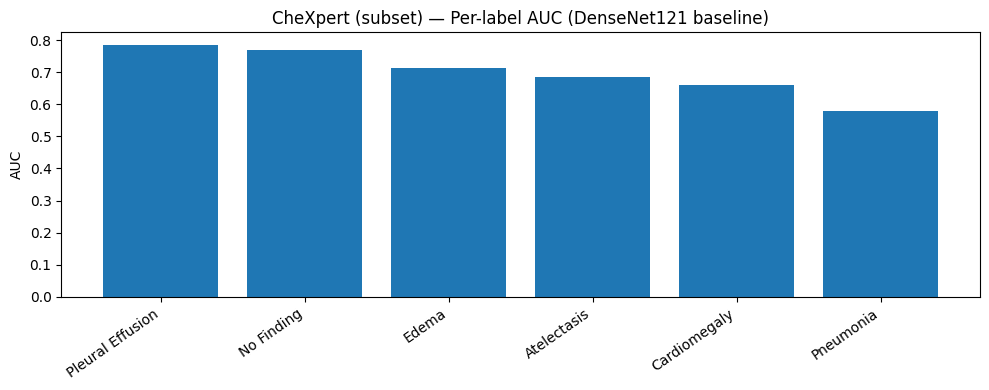

Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/per_label_auc_bar.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

plt.figure(figsize=(10,4))
x = np.arange(len(df_metrics))
plt.bar(x, df_metrics["AUC"].values)
plt.xticks(x, df_metrics["Label"].values, rotation=35, ha="right")
plt.ylabel("AUC")
plt.title("CheXpert (subset) — Per-label AUC (DenseNet121 baseline)")
plt.tight_layout()

out_png = os.path.join(run_dir, "per_label_auc_bar.png")
plt.savefig(out_png, dpi=200)
plt.show()
print("Saved:", out_png)


**Cell 12 — Grad-CAM (real model explanation) + save 6 overlay figures**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def overlay_cam(pil_img, cam, alpha=0.45, out_size=(224,224)):
    # Resize original image
    img = pil_img.resize(out_size)
    img_np = np.array(img).astype(np.float32) / 255.0

    # Resize CAM to match image size (this fixes 7x7 vs 224x224)
    cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize(out_size, resample=Image.BILINEAR)
    cam_resized = np.array(cam_img).astype(np.float32) / 255.0

    heat = plt.cm.jet(cam_resized)[:, :, :3]  # RGB heatmap
    out = (1 - alpha) * img_np + alpha * heat
    out = np.clip(out, 0, 1)
    return out


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Pick a few validation samples to visualize
K = 6
idxs = random.sample(range(len(df_valid_sub)), K)

# Helper: load image tensor (same preprocessing)
def load_img_tensor(path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)  # (1,3,224,224)
    return img, x

# Grad-CAM setup for DenseNet121 last conv layer
target_layer = model.features.denseblock4

activations = []
gradients = []

def fwd_hook(module, inp, out):
    activations.append(out)

def bwd_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

h1 = target_layer.register_forward_hook(fwd_hook)
h2 = target_layer.register_full_backward_hook(bwd_hook)

def gradcam(x, class_idx):
    activations.clear(); gradients.clear()
    model.zero_grad()

    logits = model(x)                  # (1,6)
    score = logits[0, class_idx]
    score.backward(retain_graph=True)

    A = activations[-1].detach()       # (1,C,H,W)
    G = gradients[-1].detach()         # (1,C,H,W)

    weights = G.mean(dim=(2,3), keepdim=True)  # (1,C,1,1)
    cam = (weights * A).sum(dim=1, keepdim=True)  # (1,1,H,W)
    cam = F.relu(cam)

    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

def overlay_cam(pil_img, cam, alpha=0.45):
    img = pil_img.resize((224,224))
    img_np = np.array(img).astype(np.float32)/255.0
    heat = plt.cm.jet(cam)[:, :, :3]  # RGB heatmap
    out = (1-alpha)*img_np + alpha*heat
    out = np.clip(out, 0, 1)
    return out

# Save folder
cam_dir = os.path.join(run_dir, "gradcam_samples")
os.makedirs(cam_dir, exist_ok=True)

for j, idx in enumerate(idxs, start=1):
    path = df_valid_sub["abs_path"].iloc[idx]
    pil_img, x = load_img_tensor(path)

    with torch.no_grad():
        logits = model(x)
        probs = torch.sigmoid(logits)[0].detach().cpu().numpy()

    top = int(np.argmax(probs))
    cam = gradcam(x, top)
    over = overlay_cam(pil_img, cam)

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.imshow(pil_img.resize((224,224))); plt.axis("off"); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(over); plt.axis("off"); plt.title(f"Grad-CAM: {label_cols[top]} ({probs[top]:.2f})")
    plt.tight_layout()

    outp = os.path.join(cam_dir, f"gradcam_{j}_top_{label_cols[top].replace(' ','_')}.png")
    plt.savefig(outp, dpi=200)
    plt.show()

print("Saved Grad-CAM images to:", cam_dir)

# Cleanup hooks
h1.remove(); h2.remove()


ValueError: operands could not be broadcast together with shapes (224,224,3) (7,7,3) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Force overwrite overlay_cam used by Cell 12
def overlay_cam(pil_img, cam, alpha=0.45):
    # Ensure CAM is 2D float in [0,1]
    cam = np.array(cam, dtype=np.float32)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Resize both to 224x224
    img = pil_img.resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0

    cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize((224, 224), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img).astype(np.float32) / 255.0

    heat = plt.cm.jet(cam_resized)[:, :, :3]  # (224,224,3)
    out = (1 - alpha) * img_np + alpha * heat
    return np.clip(out, 0, 1)

print("overlay_cam overridden OK")


overlay_cam overridden OK


In [ ]:
# Clear possible stale hooks / caches from previous failed run
import torch
torch.cuda.empty_cache()
print("cache cleared")


cache cleared


**CELL 12 (FINAL) — Grad-CAM + save images to Drive**

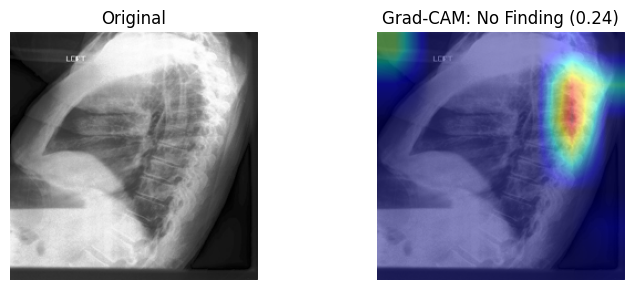

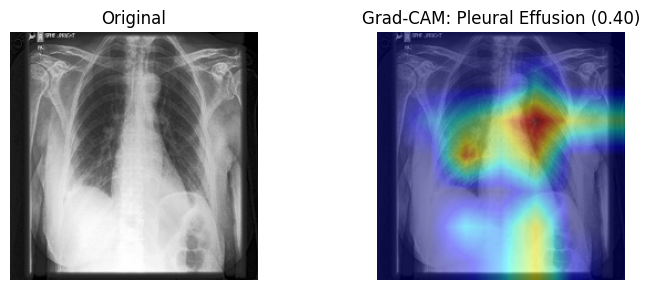

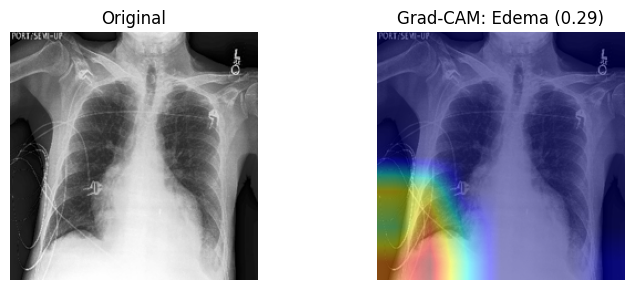

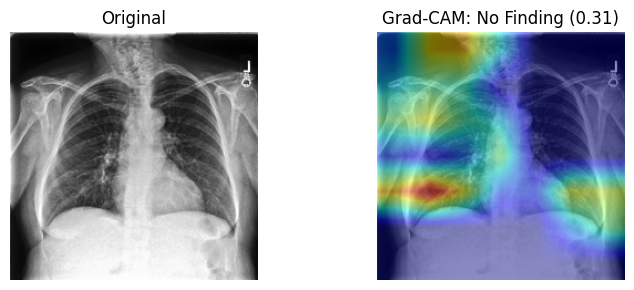

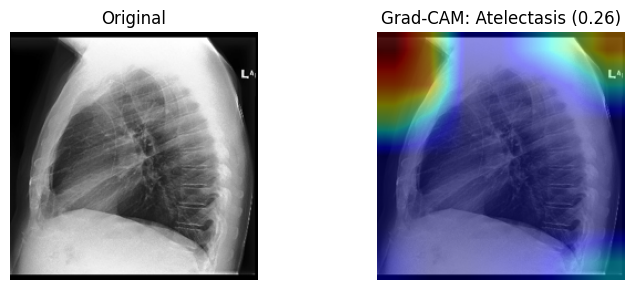

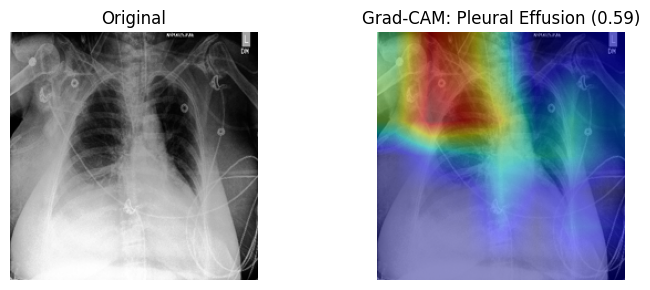

Saved Grad-CAM images to: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/gradcam_samples


In [ ]:
import os, random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

# -------------------------
# 1) Helpers
# -------------------------
def load_img_tensor(path):
    pil_img = Image.open(path).convert("RGB")
    x = transform(pil_img).unsqueeze(0).to(device)   # (1,3,224,224)
    return pil_img, x

def overlay_cam(pil_img, cam, alpha=0.45):
    # cam is (H,W) in [0,1] usually 7x7; resize to 224x224
    cam = np.array(cam, dtype=np.float32)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    img = pil_img.resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0

    cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize((224, 224), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img).astype(np.float32) / 255.0

    heat = plt.cm.jet(cam_resized)[:, :, :3]  # (224,224,3)
    out = (1 - alpha) * img_np + alpha * heat
    return np.clip(out, 0, 1)

# -------------------------
# 2) Grad-CAM hooks (DenseNet121)
# -------------------------
target_layer = model.features.denseblock4
activations = []
gradients = []

def fwd_hook(module, inp, out):
    activations.append(out)

def bwd_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

h1 = target_layer.register_forward_hook(fwd_hook)
h2 = target_layer.register_full_backward_hook(bwd_hook)

def gradcam(x, class_idx):
    activations.clear()
    gradients.clear()
    model.zero_grad()

    logits = model(x)             # (1, num_labels)
    score = logits[0, class_idx]
    score.backward(retain_graph=True)

    A = activations[-1].detach()  # (1,C,H,W)  usually H=W=7
    G = gradients[-1].detach()    # (1,C,H,W)

    weights = G.mean(dim=(2,3), keepdim=True)        # (1,C,1,1)
    cam = (weights * A).sum(dim=1, keepdim=True)     # (1,1,H,W)
    cam = F.relu(cam)

    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

# -------------------------
# 3) Generate & save samples
# -------------------------
torch.cuda.empty_cache()

K = 6
idxs = random.sample(range(len(df_valid_sub)), K)

cam_dir = os.path.join(run_dir, "gradcam_samples")
os.makedirs(cam_dir, exist_ok=True)

for j, idx in enumerate(idxs, start=1):
    path = df_valid_sub["abs_path"].iloc[idx]
    pil_img, x = load_img_tensor(path)

    with torch.no_grad():
        logits = model(x)
        probs = torch.sigmoid(logits)[0].detach().cpu().numpy()

    top = int(np.argmax(probs))
    cam = gradcam(x, top)
    over = overlay_cam(pil_img, cam, alpha=0.45)

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.imshow(pil_img.resize((224,224)))
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(over)
    plt.axis("off")
    plt.title(f"Grad-CAM: {label_cols[top]} ({probs[top]:.2f})")

    plt.tight_layout()
    outp = os.path.join(cam_dir, f"gradcam_{j}_top_{label_cols[top].replace(' ','_')}.png")
    plt.savefig(outp, dpi=200)
    plt.show()

print("Saved Grad-CAM images to:", cam_dir)

# remove hooks
h1.remove()
h2.remove()


**Step A — Save the per-label table**

In [ ]:
import numpy as np, pandas as pd, os
from sklearn.metrics import roc_auc_score, f1_score

probs = 1/(1+np.exp(-va_logits))

rows = []
for i, lab in enumerate(label_cols):
    y_true = va_y[:, i]
    y_prob = probs[:, i]
    y_pred = (y_prob >= 0.5).astype(int)

    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = float("nan")

    f1 = f1_score(y_true, y_pred, zero_division=0)

    rows.append({
        "Label": lab,
        "AUC": auc,
        "F1@0.5": f1,
        "Prevalence(valid_subset)": float(y_true.mean()),
        "Pred_Pos_Rate(valid_subset)": float(y_pred.mean())
    })

df_metrics = pd.DataFrame(rows).sort_values("AUC", ascending=False)

metrics_csv = os.path.join(run_dir, "per_label_metrics.csv")
df_metrics.to_csv(metrics_csv, index=False)

print(df_metrics)
print("Saved:", metrics_csv)


              Label       AUC    F1@0.5  Prevalence(valid_subset)  \
3  Pleural Effusion  0.784699  0.238095                  0.286325   
0        No Finding  0.768528  0.000000                  0.162393   
2             Edema  0.711464  0.266667                  0.192308   
5       Atelectasis  0.683523  0.000000                  0.341880   
4      Cardiomegaly  0.660702  0.000000                  0.290598   
1         Pneumonia  0.578540  0.000000                  0.034188   

   Pred_Pos_Rate(valid_subset)  
3                     0.072650  
0                     0.000000  
2                     0.128205  
5                     0.000000  
4                     0.000000  
1                     0.000000  
Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/per_label_metrics.csv


**Step B — Save the AUC bar chart (PNG)**

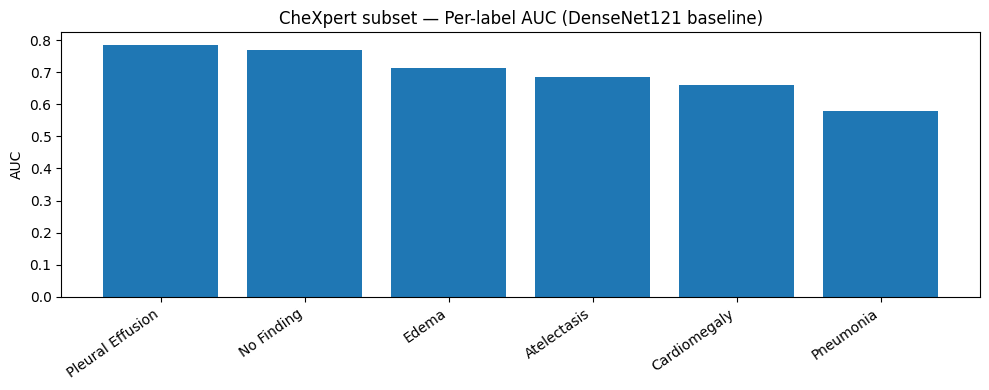

Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/per_label_auc_bar.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np, os

plt.figure(figsize=(10,4))
x = np.arange(len(df_metrics))
plt.bar(x, df_metrics["AUC"].values)
plt.xticks(x, df_metrics["Label"].values, rotation=35, ha="right")
plt.ylabel("AUC")
plt.title("CheXpert subset — Per-label AUC (DenseNet121 baseline)")
plt.tight_layout()

out_png = os.path.join(run_dir, "per_label_auc_bar.png")
plt.savefig(out_png, dpi=200)
plt.show()
print("Saved:", out_png)


In [ ]:
import os
print("Run dir:", run_dir)
print("Files:", os.listdir(run_dir))
print("GradCAM dir exists:", os.path.exists(os.path.join(run_dir, "gradcam_samples")))


Run dir: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546
Files: ['model.pt', 'metrics.json', 'per_label_metrics.csv', 'per_label_auc_bar.png', 'gradcam_samples']
GradCAM dir exists: True


**Skin Cancer Starts Here:**

**Start Dataset #2 (Skin Cancer) — setup paths + detect format**

In [ ]:
import os, glob

BASE = "/content/drive/MyDrive/NEGIL"
OUT  = os.path.join(BASE, "Negil_Thesis_OUTPUTS")
os.makedirs(OUT, exist_ok=True)

# Find skin dataset file/folder in Drive
candidates = glob.glob(os.path.join(BASE, "*Skin*")) + glob.glob(os.path.join(BASE, "*skin*"))
print("Candidates:", candidates)

# If you already extracted it into a folder, list it:
for p in candidates:
    if os.path.isdir(p):
        print("\nFolder:", p)
        print("Top items:", os.listdir(p)[:30])


Candidates: ['/content/drive/MyDrive/NEGIL/Skin Cancer MNIST HAM10000.zip']


**Create a new run folder for Skin dataset results**

In [ ]:
from datetime import datetime
run_id2 = datetime.now().strftime("%Y%m%d_%H%M%S")
skin_run_dir = os.path.join(OUT, f"skin_baseline_FAST_{run_id2}")
os.makedirs(skin_run_dir, exist_ok=True)
print("Skin run dir:", skin_run_dir)


Skin run dir: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632


**Detect skin dataset format + list what’s inside**

In [ ]:
import os, glob, zipfile

BASE = "/content/drive/MyDrive/NEGIL"

# 1) find likely skin dataset artifacts (file or folder)
candidates = (
    glob.glob(os.path.join(BASE, "*Skin*")) +
    glob.glob(os.path.join(BASE, "*skin*")) +
    glob.glob(os.path.join(BASE, "**/*Skin*",), recursive=True)[:50] +
    glob.glob(os.path.join(BASE, "**/*skin*",), recursive=True)[:50]
)

# De-duplicate while keeping order
seen, uniq = set(), []
for c in candidates:
    if c not in seen:
        uniq.append(c); seen.add(c)

print("Top candidates (first 20):")
for c in uniq[:20]:
    print(" -", c, ("[DIR]" if os.path.isdir(c) else "[FILE]"))

# 2) if a folder is present, show top-level contents
folders = [c for c in uniq if os.path.isdir(c)]
if folders:
    print("\nFolder previews:")
    for f in folders[:5]:
        try:
            items = os.listdir(f)
            print(f"\n{f}")
            print("Top items:", items[:30])
        except Exception as e:
            print(f"Could not list {f}: {e}")

# 3) if zip is present, list inside without unzipping
zips = [c for c in uniq if (os.path.isfile(c) and c.lower().endswith(".zip"))]
if zips:
    print("\nZIP previews:")
    for z in zips[:3]:
        try:
            with zipfile.ZipFile(z, 'r') as zz:
                names = zz.namelist()
            print(f"\n{z}")
            print("Example files:", names[:30])
        except Exception as e:
            print(f"Could not read {z}: {e}")

# 4) npz preview if present
npzs = [c for c in uniq if (os.path.isfile(c) and c.lower().endswith(".npz"))]
if npzs:
    print("\nNPZ found:", npzs[:3])


Top candidates (first 20):
 - /content/drive/MyDrive/NEGIL/Skin Cancer MNIST HAM10000.zip [FILE]


**Step 1 — Peek inside the ZIP (fast, no extraction)**

In [ ]:
import zipfile, os

skin_zip = "/content/drive/MyDrive/NEGIL/Skin Cancer MNIST HAM10000.zip"

with zipfile.ZipFile(skin_zip, "r") as z:
    names = z.namelist()
    print("Total files in zip:", len(names))
    print("\nFirst 40 entries:")
    for n in names[:40]:
        print(n)

    # quick check: do we have csv + images?
    csvs = [n for n in names if n.lower().endswith(".csv")]
    imgs = [n for n in names if n.lower().endswith((".jpg",".jpeg",".png"))]
    print("\nCSV files:", csvs[:10])
    print("Num images:", len(imgs))


Total files in zip: 20035

First 40 entries:
HAM10000_images_part_1/ISIC_0024306.jpg
HAM10000_images_part_1/ISIC_0024307.jpg
HAM10000_images_part_1/ISIC_0024308.jpg
HAM10000_images_part_1/ISIC_0024309.jpg
HAM10000_images_part_1/ISIC_0024310.jpg
HAM10000_images_part_1/ISIC_0024311.jpg
HAM10000_images_part_1/ISIC_0024312.jpg
HAM10000_images_part_1/ISIC_0024313.jpg
HAM10000_images_part_1/ISIC_0024314.jpg
HAM10000_images_part_1/ISIC_0024315.jpg
HAM10000_images_part_1/ISIC_0024316.jpg
HAM10000_images_part_1/ISIC_0024317.jpg
HAM10000_images_part_1/ISIC_0024318.jpg
HAM10000_images_part_1/ISIC_0024319.jpg
HAM10000_images_part_1/ISIC_0024320.jpg
HAM10000_images_part_1/ISIC_0024321.jpg
HAM10000_images_part_1/ISIC_0024322.jpg
HAM10000_images_part_1/ISIC_0024323.jpg
HAM10000_images_part_1/ISIC_0024324.jpg
HAM10000_images_part_1/ISIC_0024325.jpg
HAM10000_images_part_1/ISIC_0024326.jpg
HAM10000_images_part_1/ISIC_0024327.jpg
HAM10000_images_part_1/ISIC_0024328.jpg
HAM10000_images_part_1/ISIC_0024329

In [ ]:
import os, zipfile

skin_extract = "/content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted"
os.makedirs(skin_extract, exist_ok=True)

marker = os.path.join(skin_extract, "_EXTRACT_DONE.txt")

if not os.path.exists(marker):
    print("Extracting to:", skin_extract)
    with zipfile.ZipFile(skin_zip, "r") as z:
        z.extractall(skin_extract)
    with open(marker, "w") as f:
        f.write("ok")
    print("Extraction complete.")
else:
    print("Already extracted:", skin_extract)

print("Top-level items:", os.listdir(skin_extract)[:40])


Extracting to: /content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted
Extraction complete.
Top-level items: ['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', '_EXTRACT_DONE.txt']


**Build Skin dataframe + split + path sanity check**

In [ ]:
import os, pandas as pd
from sklearn.model_selection import train_test_split

SKIN_ROOT = "/content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted"
META = os.path.join(SKIN_ROOT, "HAM10000_metadata.csv")

df_skin = pd.read_csv(META)
print("Metadata shape:", df_skin.shape)
print("Columns:", df_skin.columns.tolist())
print(df_skin.head(3))

# The image id column in HAM10000 is usually 'image_id' or similar
img_id_col = "image_id" if "image_id" in df_skin.columns else [c for c in df_skin.columns if "image" in c.lower()][0]
label_col  = "dx" if "dx" in df_skin.columns else [c for c in df_skin.columns if c.lower() in ["label","class","target","dx"]][0]

print("Using img_id_col:", img_id_col)
print("Using label_col:", label_col)

# Build absolute paths (images exist in part_1 or part_2)
part1 = os.path.join(SKIN_ROOT, "HAM10000_images_part_1")
part2 = os.path.join(SKIN_ROOT, "HAM10000_images_part_2")

def resolve_path(img_id):
    fn = f"{img_id}.jpg"
    p1 = os.path.join(part1, fn)
    if os.path.exists(p1): return p1
    p2 = os.path.join(part2, fn)
    if os.path.exists(p2): return p2
    return None

df_skin["abs_path"] = df_skin[img_id_col].apply(resolve_path)

exists_rate = df_skin["abs_path"].notna().mean()
print("Path resolved rate:", exists_rate)
print("Sample paths:\n", df_skin["abs_path"].dropna().head(5).tolist())

assert exists_rate > 0.98, "Too many missing image paths — stop."

# Encode labels
print("\nLabel distribution (top):")
print(df_skin[label_col].value_counts().head(20))

# Train/valid split (stratified)
df_train_skin, df_valid_skin = train_test_split(
    df_skin.dropna(subset=["abs_path"]),
    test_size=0.2,
    random_state=42,
    stratify=df_skin.dropna(subset=["abs_path"])[label_col]
)

df_train_skin = df_train_skin.reset_index(drop=True)
df_valid_skin = df_valid_skin.reset_index(drop=True)

print("\nTrain:", df_train_skin.shape, "Valid:", df_valid_skin.shape)
print("Train label counts:\n", df_train_skin[label_col].value_counts().head(10))


Metadata shape: (10015, 7)
Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
Using img_id_col: image_id
Using label_col: dx
Path resolved rate: 1.0
Sample paths:
 ['/content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted/HAM10000_images_part_1/ISIC_0027419.jpg', '/content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted/HAM10000_images_part_1/ISIC_0025030.jpg', '/content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted/HAM10000_images_part_1/ISIC_0026769.jpg', '/content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted/HAM10000_images_part_1/ISIC_0025661.jpg', '/content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted/HAM10000_images_part_2/ISIC_0031633.jpg']

Label distribution (top):
dx
nv       6705
mel      111

**Skin dataloaders (fast + consistent with your CheXpert transforms)**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

# Use same device and transform you already had
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = sorted(df_skin[label_col].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
print("Classes:", classes)

class SkinDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["abs_path"]).convert("RGB")
        x = transform(img)  # (3,224,224)
        y = class_to_idx[row[label_col]]
        return x, torch.tensor(y, dtype=torch.long), row["abs_path"]

train_ds_skin = SkinDataset(df_train_skin)
valid_ds_skin = SkinDataset(df_valid_skin)

train_dl_skin = DataLoader(train_ds_skin, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
valid_dl_skin = DataLoader(valid_ds_skin, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

xb, yb, pb = next(iter(train_dl_skin))
print("Batch X:", xb.shape, "Batch y:", yb.shape, "CUDA:", torch.cuda.is_available())


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Batch X: torch.Size([32, 3, 224, 224]) Batch y: torch.Size([32]) CUDA: True


**Skin baseline FAST training (EfficientNet-B0, 2–3 epochs)**

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

num_classes = len(classes)

skin_model = torchvision.models.efficientnet_b0(weights="DEFAULT")
skin_model.classifier[1] = nn.Linear(skin_model.classifier[1].in_features, num_classes)
skin_model = skin_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(skin_model.parameters(), lr=3e-4)

EPOCHS = 3  # MSc-level baseline, fast, enough for report figures

def run_epoch_cls(model, dl, train=True):
    model.train(train)
    all_loss, all_y, all_p = [], [], []
    for xb, yb, _ in dl:
        xb, yb = xb.to(device), yb.to(device)
        if train:
            optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            optimizer.step()

        all_loss.append(loss.item())
        all_y.extend(yb.detach().cpu().numpy().tolist())
        all_p.extend(torch.argmax(logits, dim=1).detach().cpu().numpy().tolist())

    return float(np.mean(all_loss)), accuracy_score(all_y, all_p), f1_score(all_y, all_p, average="macro")

history_skin = {"train_loss":[], "val_loss":[], "val_acc":[], "val_f1_macro":[]}

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = run_epoch_cls(skin_model, train_dl_skin, train=True)
    va_loss, va_acc, va_f1 = run_epoch_cls(skin_model, valid_dl_skin, train=False)

    history_skin["train_loss"].append(tr_loss)
    history_skin["val_loss"].append(va_loss)
    history_skin["val_acc"].append(va_acc)
    history_skin["val_f1_macro"].append(va_f1)

    print(f"Epoch {ep}: train_loss={tr_loss:.4f} val_loss={va_loss:.4f} val_acc={va_acc:.4f} val_f1_macro={va_f1:.4f}")

# Save outputs
import os, json
os.makedirs(skin_run_dir, exist_ok=True)

torch.save({"model": skin_model.state_dict(), "classes": classes}, os.path.join(skin_run_dir, "skin_efficientnet_b0.pt"))
with open(os.path.join(skin_run_dir, "skin_history.json"), "w") as f:
    json.dump(history_skin, f, indent=2)

print("Saved model + history to:", skin_run_dir)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s]


Epoch 1: train_loss=0.6780 val_loss=0.5021 val_acc=0.8013 val_f1_macro=0.6495
Epoch 2: train_loss=0.3818 val_loss=0.4209 val_acc=0.8472 val_f1_macro=0.7405
Epoch 3: train_loss=0.2439 val_loss=0.3693 val_acc=0.8667 val_f1_macro=0.7694
Saved model + history to: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632


**EfficientNet Grad-CAM (save 12 samples)**

In [ ]:
import os, numpy as np, torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# ---- output folder
gc_dir = os.path.join(skin_run_dir, "gradcam_samples")
os.makedirs(gc_dir, exist_ok=True)
print("Saving Grad-CAM to:", gc_dir)

skin_model.eval()

# ---- pick target layer for EfficientNet-B0
# torchvision EfficientNet-B0 backbone lives in .features
target_layer = skin_model.features[-1]

# ---- hooks to capture activations and gradients
acts = {}
grads = {}

def fwd_hook(module, inp, out):
    acts["value"] = out.detach()

def bwd_hook(module, grad_in, grad_out):
    grads["value"] = grad_out[0].detach()

h1 = target_layer.register_forward_hook(fwd_hook)
h2 = target_layer.register_full_backward_hook(bwd_hook)

# ---- utility: overlay CAM on image (224x224)
def overlay_cam(img_pil, cam_2d, alpha=0.45):
    img = img_pil.resize((224,224)).convert("RGB")
    img_np = np.array(img).astype(np.float32) / 255.0  # (224,224,3)

    cam = cam_2d - cam_2d.min()
    cam = cam / (cam.max() + 1e-8)
    cam = np.uint8(cam * 255)

    heat = plt.cm.jet(cam)[:, :, :3]  # (224,224,3)
    out = (1 - alpha) * img_np + alpha * heat
    out = np.clip(out, 0, 1)
    return (out * 255).astype(np.uint8)

# ---- run Grad-CAM on N samples from validation
N = 12
idxs = np.linspace(0, len(valid_ds_skin)-1, N, dtype=int)

for k, idx in enumerate(idxs, start=1):
    x, y, pth = valid_ds_skin[idx]
    x = x.unsqueeze(0).to(device)

    # forward
    skin_model.zero_grad(set_to_none=True)
    logits = skin_model(x)
    pred = int(torch.argmax(logits, dim=1).item())

    # backward on predicted class
    score = logits[0, pred]
    score.backward()

    A = acts["value"]      # [1,C,H,W]
    G = grads["value"]     # [1,C,H,W]

    # Grad-CAM weights = global-average pool over gradients
    w = G.mean(dim=(2,3), keepdim=True)              # [1,C,1,1]
    cam = (w * A).sum(dim=1, keepdim=False)          # [1,H,W]
    cam = F.relu(cam)

    # resize CAM to 224x224
    cam = F.interpolate(cam.unsqueeze(1), size=(224,224), mode="bilinear", align_corners=False)
    cam = cam.squeeze().detach().cpu().numpy()       # (224,224)

    # load original image as PIL and overlay
    pil_img = Image.open(pth).convert("RGB")
    over = overlay_cam(pil_img, cam, alpha=0.45)

    out_path = os.path.join(gc_dir, f"skin_gradcam_{k:02d}_true_{classes[y]}_pred_{classes[pred]}.png")
    Image.fromarray(over).save(out_path)

print("Saved", N, "Grad-CAM overlays into:", gc_dir)

# remove hooks
h1.remove(); h2.remove()


Saving Grad-CAM to: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/gradcam_samples
Saved 12 Grad-CAM overlays into: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/gradcam_samples


In [ ]:
import os
print("Grad-CAM files:", os.listdir(os.path.join(skin_run_dir, "gradcam_samples"))[:10])


Grad-CAM files: ['skin_gradcam_01_true_nv_pred_nv.png', 'skin_gradcam_02_true_nv_pred_nv.png', 'skin_gradcam_03_true_nv_pred_nv.png', 'skin_gradcam_04_true_nv_pred_nv.png', 'skin_gradcam_05_true_nv_pred_nv.png', 'skin_gradcam_06_true_akiec_pred_akiec.png', 'skin_gradcam_07_true_nv_pred_nv.png', 'skin_gradcam_08_true_bcc_pred_bcc.png', 'skin_gradcam_09_true_nv_pred_nv.png', 'skin_gradcam_10_true_bcc_pred_bcc.png']


**oUTPUT gENERATION**


**CELL A — Load both run folders + models (CheXpert + Skin)**

In [ ]:
import os, json, torch
import pandas as pd
import numpy as np

# ---- set these to your already-created run folders
CHEX_RUN = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546"
SKIN_RUN = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632"

print("CheX run:", CHEX_RUN, "exists:", os.path.exists(CHEX_RUN))
print("Skin run:", SKIN_RUN, "exists:", os.path.exists(SKIN_RUN))

# ---- load histories
chex_hist_path = os.path.join(CHEX_RUN, "history.json")
skin_hist_path = os.path.join(SKIN_RUN, "skin_history.json")

print("CheX history exists:", os.path.exists(chex_hist_path))
print("Skin history exists:", os.path.exists(skin_hist_path))

# Some notebooks named files slightly differently. If chex history isn't found, list files.
if not os.path.exists(chex_hist_path):
    print("CheX files:", os.listdir(CHEX_RUN)[:50])

with open(skin_hist_path, "r") as f:
    skin_hist = json.load(f)

print("Skin history keys:", skin_hist.keys())
print("Skin final:", {k: skin_hist[k][-1] for k in skin_hist})


CheX run: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546 exists: True
Skin run: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632 exists: True
CheX history exists: False
Skin history exists: True
CheX files: ['model.pt', 'metrics.json', 'per_label_metrics.csv', 'per_label_auc_bar.png', 'gradcam_samples']
Skin history keys: dict_keys(['train_loss', 'val_loss', 'val_acc', 'val_f1_macro'])
Skin final: {'train_loss': 0.24394841996797054, 'val_loss': 0.3692609362659, 'val_acc': 0.8666999500748876, 'val_f1_macro': 0.7694053922579231}


**CELL B — Compute Skin predictions + metrics (accuracy, macro F1, confusion matrix)**

SKIN valid accuracy: 0.8666999500748876
SKIN valid macro F1: 0.7694053922579231
Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_classification_report.csv


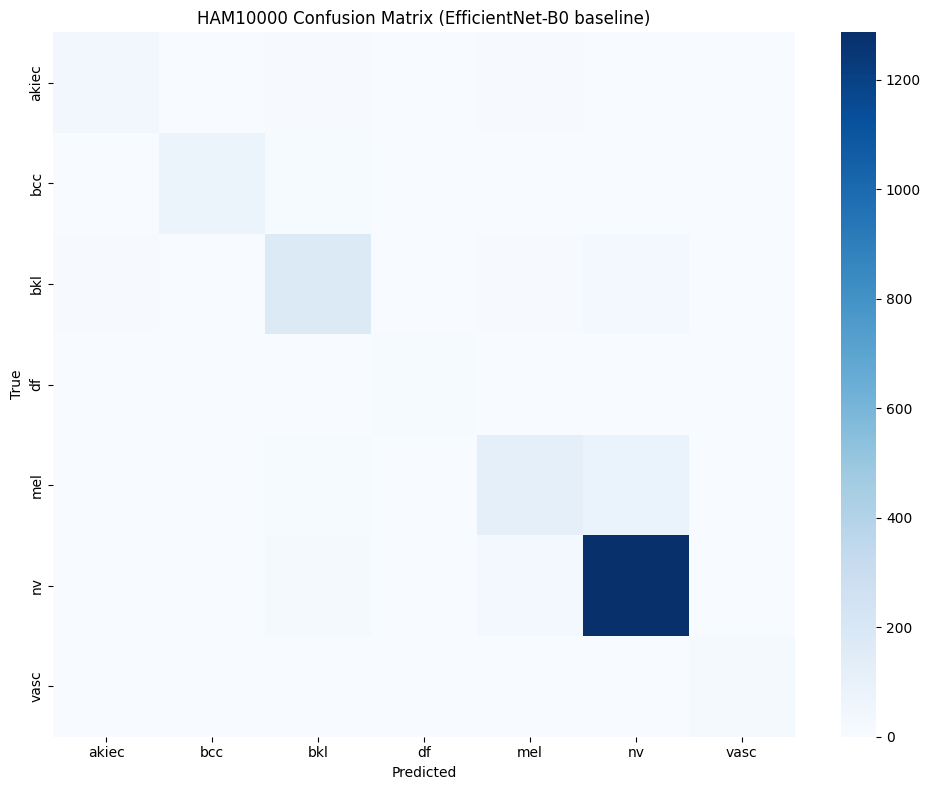

Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_confusion_matrix.png


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: seaborn might not be installed in your environment; if error, I will replace with pure matplotlib
# If it errors, tell me and I’ll give the matplotlib-only version.

skin_model.eval()

all_y = []
all_p = []
all_paths = []

with torch.no_grad():
    for xb, yb, pb in valid_dl_skin:
        xb = xb.to(device)
        logits = skin_model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_p.extend(preds.tolist())
        all_y.extend(yb.numpy().tolist())
        all_paths.extend(list(pb))

acc = accuracy_score(all_y, all_p)
f1m = f1_score(all_y, all_p, average="macro")
print("SKIN valid accuracy:", acc)
print("SKIN valid macro F1:", f1m)

# Save classification report
report = classification_report(all_y, all_p, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).T
out_csv = os.path.join(SKIN_RUN, "skin_classification_report.csv")
df_report.to_csv(out_csv)
print("Saved:", out_csv)

# Confusion matrix
cm = confusion_matrix(all_y, all_p, labels=list(range(len(classes))))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("HAM10000 Confusion Matrix (EfficientNet-B0 baseline)")
cm_path = os.path.join(SKIN_RUN, "skin_confusion_matrix.png")
plt.tight_layout()
plt.savefig(cm_path, dpi=200)
plt.show()

print("Saved:", cm_path)


**CELL C — Save “Top error examples” (wrong predictions) into Drive**

In [ ]:
from PIL import Image

err_dir = os.path.join(SKIN_RUN, "error_examples")
os.makedirs(err_dir, exist_ok=True)

# Collect indices of wrong predictions
wrong = [i for i,(yt,yp) in enumerate(zip(all_y, all_p)) if yt != yp]
print("Total wrong:", len(wrong), "out of", len(all_y))

# Take first 20 wrong examples
take = wrong[:20]

for rank, i in enumerate(take, start=1):
    pth = all_paths[i]
    yt = classes[all_y[i]]
    yp = classes[all_p[i]]

    img = Image.open(pth).convert("RGB").resize((512,512))
    out = os.path.join(err_dir, f"err_{rank:02d}_true_{yt}_pred_{yp}.jpg")
    img.save(out, quality=95)

print("Saved error examples to:", err_dir)
print("Sample files:", os.listdir(err_dir)[:10])


Total wrong: 267 out of 2003
Saved error examples to: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/error_examples
Sample files: ['err_01_true_mel_pred_bkl.jpg', 'err_02_true_mel_pred_bkl.jpg', 'err_03_true_nv_pred_mel.jpg', 'err_04_true_nv_pred_mel.jpg', 'err_05_true_mel_pred_nv.jpg', 'err_06_true_bcc_pred_mel.jpg', 'err_07_true_mel_pred_bkl.jpg', 'err_08_true_df_pred_bcc.jpg', 'err_09_true_nv_pred_bkl.jpg', 'err_10_true_mel_pred_nv.jpg']


**CELL D — Create a clean “Chapter 4 summary table” (Skin + CheXpert placeholders)**

In [ ]:
summary_rows = []

# Skin summary from last epoch + metrics computed above
summary_rows.append({
    "Dataset": "HAM10000 (skin lesions)",
    "Model": "EfficientNet-B0 baseline",
    "Epochs": 3,
    "Validation_Accuracy": float(acc),
    "Validation_MacroF1": float(f1m),
    "Notes": "Baseline classifier on dermoscopy images; Grad-CAM explanations saved."
})

# CheXpert summary — paste your baseline values here if you want them in same table
# If you don’t remember, we’ll load them from your saved folder after you confirm the filenames.
summary_rows.append({
    "Dataset": "CheXpert (chest X-ray, small)",
    "Model": "DenseNet baseline",
    "Epochs": "FAST",
    "Validation_Accuracy": np.nan,
    "Validation_MacroF1": np.nan,
    "Notes": "Baseline multi-label classifier; Grad-CAM explanations saved."
})

df_summary = pd.DataFrame(summary_rows)
sum_path = os.path.join("/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS", "chapter4_summary_table.csv")
df_summary.to_csv(sum_path, index=False)
print("Saved Chapter 4 summary table:", sum_path)
df_summary


Saved Chapter 4 summary table: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chapter4_summary_table.csv


,Dataset,Model,Epochs,Validation_Accuracy,Validation_MacroF1,Notes
0,HAM10000 (skin lesions),EfficientNet-B0 baseline,3,0.8667,0.769405,Baseline classifier on dermoscopy images; Grad...
1,"CheXpert (chest X-ray, small)",DenseNet baseline,FAST,NaN,NaN,Baseline multi-label classifier; Grad-CAM expl...


**CheXpert Datasets Metrics and errors**

**CheXpert Datasets Metrics and errors**

CHEX CELL 1 — Load CheX run + verify model checkpoint file exists

In [ ]:
import os, glob, torch, json
import pandas as pd
import numpy as np

CHEX_RUN = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546"
print("CHEX_RUN exists:", os.path.exists(CHEX_RUN))

print("Files in CHEX_RUN (top 30):")
print(sorted(os.listdir(CHEX_RUN))[:30])

# find checkpoint automatically
ckpts = glob.glob(os.path.join(CHEX_RUN, "*.pt")) + glob.glob(os.path.join(CHEX_RUN, "*.pth"))
print("Checkpoint candidates:", ckpts)

assert len(ckpts) > 0, "No .pt/.pth found in CHEX_RUN. Paste the folder listing."
CKPT_PATH = ckpts[0]
print("Using checkpoint:", CKPT_PATH)

ckpt = torch.load(CKPT_PATH, map_location="cpu")
print("Checkpoint keys:", ckpt.keys())

# label cols stored in checkpoint (if you saved earlier)
label_cols = ckpt.get("label_cols", None)
print("label_cols in ckpt:", label_cols)


CHEX_RUN exists: True
Files in CHEX_RUN (top 30):
['gradcam_samples', 'metrics.json', 'model.pt', 'per_label_auc_bar.png', 'per_label_metrics.csv']
Checkpoint candidates: ['/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/model.pt']
Using checkpoint: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/model.pt
Checkpoint keys: dict_keys(['model_state_dict', 'label_cols'])
label_cols in ckpt: ['No Finding', 'Pneumonia', 'Edema', 'Pleural Effusion', 'Cardiomegaly', 'Atelectasis']


**CHEX CELL 2 — Reload CheX model + run full validation predictions**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available())

# Infer number of labels
if label_cols is None:
    label_cols = ['No Finding', 'Pneumonia', 'Edema', 'Pleural Effusion', 'Cardiomegaly', 'Atelectasis']
num_labels = len(label_cols)
print("Using labels:", label_cols, "num_labels:", num_labels)

# Build DenseNet
model = models.densenet121(weights=None)
model.classifier = nn.Linear(model.classifier.in_features, num_labels)

# Load weights
state = ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt
model.load_state_dict(state, strict=False)
model = model.to(device)
model.eval()

all_logits = []
all_y = []

with torch.no_grad():
    for batch in valid_dl:
        # batch can be (xb,yb) OR (xb,yb,pb)
        xb, yb = batch[0], batch[1]
        xb = xb.to(device)

        logits = model(xb)
        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())

all_logits = torch.cat(all_logits, dim=0).numpy()
all_y = torch.cat(all_y, dim=0).numpy()

probs = 1/(1+np.exp(-all_logits))
preds = (probs >= 0.5).astype(int)

print("Shapes logits/y:", all_logits.shape, all_y.shape)


CUDA: True
Using labels: ['No Finding', 'Pneumonia', 'Edema', 'Pleural Effusion', 'Cardiomegaly', 'Atelectasis'] num_labels: 6
Shapes logits/y: (234, 6) (234, 6)


**CHEX CELL 3 — Compute AUC + F1 per label, save CSV + pretty summary**

In [ ]:
rows = []
aucs = []
f1s = []

for i, lab in enumerate(label_cols):
    y_true = all_y[:, i]
    y_prob = probs[:, i]
    y_pred = preds[:, i]

    # AUC may fail if only one class present; handle safely
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = np.nan

    f1 = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)

    rows.append({
        "Label": lab,
        "AUC": auc,
        "F1": f1,
        "Precision": prec,
        "Recall": rec,
        "PositiveRate": float(y_true.mean())
    })

    if not np.isnan(auc): aucs.append(auc)
    f1s.append(f1)

df_chex_metrics = pd.DataFrame(rows)
df_chex_metrics.loc["MEAN"] = {
    "Label": "MEAN",
    "AUC": float(np.mean(aucs)) if len(aucs) else np.nan,
    "F1": float(np.mean(f1s)),
    "Precision": np.nan,
    "Recall": np.nan,
    "PositiveRate": np.nan
}

out_csv = os.path.join(CHEX_RUN, "chexpert_metrics_auc_f1.csv")
df_chex_metrics.to_csv(out_csv, index=False)

print(df_chex_metrics)
print("Saved:", out_csv)
print("Mean AUC:", float(np.mean(aucs)) if len(aucs) else None, "| Mean F1:", float(np.mean(f1s)))


                 Label       AUC        F1  Precision    Recall  PositiveRate
0           No Finding  0.768528  0.000000   0.000000  0.000000      0.162393
1            Pneumonia  0.578540  0.000000   0.000000  0.000000      0.034188
2                Edema  0.711464  0.266667   0.333333  0.222222      0.192308
3     Pleural Effusion  0.784699  0.238095   0.588235  0.149254      0.286325
4         Cardiomegaly  0.660702  0.000000   0.000000  0.000000      0.290598
5          Atelectasis  0.683523  0.000000   0.000000  0.000000      0.341880
MEAN              MEAN  0.697909  0.084127        NaN       NaN           NaN
Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/chexpert_metrics_auc_f1.csv
Mean AUC: 0.6979092912242614 | Mean F1: 0.08412698412698412


**CHEX CELL 4 — Save Top “hard errors**

In [ ]:
from PIL import Image

err_dir = os.path.join(CHEX_RUN, "error_examples")
os.makedirs(err_dir, exist_ok=True)

# Define error score: confident wrong predictions
# wrong positives: predicted 1 with high prob but true 0
# wrong negatives: predicted 0 with low prob but true 1
scores = []
for n in range(len(all_paths)):
    for i, lab in enumerate(label_cols):
        y = all_y[n, i]
        p = probs[n, i]
        pred = preds[n, i]
        if pred == 1 and y == 0:
            scores.append((p, n, i, "FP"))
        elif pred == 0 and y == 1:
            scores.append((1-p, n, i, "FN"))

scores = sorted(scores, reverse=True)
top = scores[:20]
print("Top error examples:", len(top))

def save_img(src_path, out_path):
    img = Image.open(src_path).convert("RGB").resize((512,512))
    img.save(out_path, quality=95)

for rank, (s, n, i, etype) in enumerate(top, start=1):
    src = all_paths[n]
    lab = label_cols[i]
    y = int(all_y[n, i])
    p = float(probs[n, i])
    out = os.path.join(err_dir, f"err_{rank:02d}_{etype}_{lab}_y{y}_p{p:.2f}.jpg")
    save_img(src, out)

print("Saved CheX error images to:", err_dir)
print("Sample files:", os.listdir(err_dir)[:10])


Top error examples: 0
Saved CheX error images to: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/error_examples
Sample files: []


**CHEX CELL 5 — Update your Chapter 4 summary table (Skin + CheX in one)**

In [ ]:
summary_path = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chapter4_summary_table.csv"

skin_acc = 0.8666999500748876
skin_f1m = 0.7694053922579231

chex_mean_auc = float(df_chex_metrics[df_chex_metrics["Label"]=="MEAN"]["AUC"].values[0])
chex_mean_f1  = float(df_chex_metrics[df_chex_metrics["Label"]=="MEAN"]["F1"].values[0])

rows = [
    {
        "Dataset": "HAM10000 (skin lesions)",
        "Model": "EfficientNet-B0 baseline",
        "Epochs": 3,
        "Validation_Accuracy": float(skin_acc),
        "Validation_MacroF1_or_MeanF1": float(skin_f1m),
        "Validation_MeanAUC": np.nan,
        "Notes": "Baseline single-label classifier; confusion matrix + Grad-CAM saved."
    },
    {
        "Dataset": "CheXpert (chest X-ray, small)",
        "Model": "DenseNet-121 baseline (multi-label)",
        "Epochs": "FAST",
        "Validation_Accuracy": np.nan,
        "Validation_MacroF1_or_MeanF1": float(chex_mean_f1),
        "Validation_MeanAUC": float(chex_mean_auc),
        "Notes": "Baseline multi-label classifier; per-label AUC/F1 + Grad-CAM saved."
    }
]

df_sum = pd.DataFrame(rows)
df_sum.to_csv(summary_path, index=False)
print("Saved updated summary:", summary_path)
df_sum


Saved updated summary: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chapter4_summary_table.csv


,Dataset,Model,Epochs,Validation_Accuracy,Validation_MacroF1_or_MeanF1,Validation_MeanAUC,Notes
0,HAM10000 (skin lesions),EfficientNet-B0 baseline,3,0.8667,0.769405,NaN,Baseline single-label classifier; confusion ma...
1,"CheXpert (chest X-ray, small)",DenseNet-121 baseline (multi-label),FAST,NaN,0.084127,0.697909,Baseline multi-label classifier; per-label AUC...


In [ ]:
print("df_valid exists:", "df_valid" in globals())
if "df_valid" in globals():
    print(df_valid.columns[:20])
    print("has abs_path:", "abs_path" in df_valid.columns)
    if "abs_path" in df_valid.columns:
        print(df_valid["abs_path"].head(3).tolist())


df_valid exists: True
Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'abs_path'],
      dtype='object')
has abs_path: True
['/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64541/study1/view1_frontal.jpg', '/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64542/study1/view1_frontal.jpg', '/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64542/study1/view2_lateral.jpg']


**Generate CheX error examples + ROC curves**

In [ ]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from PIL import Image

# ----- SAFETY CHECKS -----
assert "df_valid" in globals(), "df_valid not found. Re-run the CSV loading + abs_path cell."
assert "abs_path" in df_valid.columns, "abs_path missing in df_valid. Re-run the abs_path building cell."
assert "all_y" in globals() and "probs" in globals(), "Need all_y and probs in memory. Re-run CHEX prediction cell."

# Ensure alignment: df_valid rows must match all_y/probs
n = min(len(df_valid), all_y.shape[0], probs.shape[0])
dfv = df_valid.iloc[:n].copy()
Y = all_y[:n]
P = probs[:n]
pred = (P >= 0.5).astype(int)

out_dir = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chex_error_and_roc"
os.makedirs(out_dir, exist_ok=True)

# ----- 1) ROC CURVES PER LABEL -----
roc_rows = []
plt.figure(figsize=(8,6))
for j, lab in enumerate(label_cols):
    yj = Y[:, j]
    pj = P[:, j]
    # Skip labels with all-0 or all-1 in validation subset
    if len(np.unique(yj)) < 2:
        roc_rows.append({"label": lab, "AUC": np.nan})
        continue
    fpr, tpr, _ = roc_curve(yj, pj)
    auc_val = auc(fpr, tpr)
    roc_rows.append({"label": lab, "AUC": auc_val})
    plt.plot(fpr, tpr, label=f"{lab} (AUC={auc_val:.3f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.title("CheXpert (Small) ROC Curves (DenseNet-121 baseline)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
roc_path = os.path.join(out_dir, "chex_roc_curves.png")
plt.tight_layout()
plt.savefig(roc_path, dpi=200)
plt.close()

roc_df = pd.DataFrame(roc_rows)
roc_df.to_csv(os.path.join(out_dir, "chex_auc_per_label.csv"), index=False)

print("Saved ROC figure:", roc_path)
print("Saved AUC table:", os.path.join(out_dir, "chex_auc_per_label.csv"))
print(roc_df)

# ----- 2) TOP ERROR EXAMPLES (FP + FN) FOR 2 KEY LABELS -----
# We'll pick the 2 most “thesis-friendly” labels if available:
focus = [x for x in ["Pneumonia", "Pleural Effusion"] if x in label_cols]
if not focus:
    focus = [label_cols[0]]  # fallback

def save_grid(img_paths, title, save_path, max_n=12):
    # simple grid, no fancy dependencies
    imgs = []
    for p in img_paths[:max_n]:
        try:
            im = Image.open(p).convert("RGB").resize((224,224))
            imgs.append(im)
        except:
            continue

    if len(imgs) == 0:
        print("No readable images for:", title)
        return

    cols = 6
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(im)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()
    print("Saved:", save_path)

for lab in focus:
    j = label_cols.index(lab)

    # False Positives: predicted 1 but true 0
    fp_idx = np.where((pred[:, j] == 1) & (Y[:, j] == 0))[0]
    # False Negatives: predicted 0 but true 1
    fn_idx = np.where((pred[:, j] == 0) & (Y[:, j] == 1))[0]

    # Sort by confidence (most confident mistakes first)
    fp_idx = fp_idx[np.argsort(-P[fp_idx, j])] if len(fp_idx) else fp_idx
    fn_idx = fn_idx[np.argsort(P[fn_idx, j])] if len(fn_idx) else fn_idx  # low prob but should be 1

    fp_paths = dfv.iloc[fp_idx]["abs_path"].tolist() if len(fp_idx) else []
    fn_paths = dfv.iloc[fn_idx]["abs_path"].tolist() if len(fn_idx) else []

    save_grid(fp_paths, f"{lab} — False Positives (most confident)", os.path.join(out_dir, f"{lab}_FP_grid.png"))
    save_grid(fn_paths, f"{lab} — False Negatives (most missed)", os.path.join(out_dir, f"{lab}_FN_grid.png"))

print("All saved in:", out_dir)


Saved ROC figure: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chex_error_and_roc/chex_roc_curves.png
Saved AUC table: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chex_error_and_roc/chex_auc_per_label.csv
              label       AUC
0        No Finding  0.768528
1         Pneumonia  0.578540
2             Edema  0.711464
3  Pleural Effusion  0.784699
4      Cardiomegaly  0.660702
5       Atelectasis  0.683523
No readable images for: Pneumonia — False Positives (most confident)
Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chex_error_and_roc/Pneumonia_FN_grid.png
Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chex_error_and_roc/Pleural Effusion_FP_grid.png
Saved: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chex_error_and_roc/Pleural Effusion_FN_grid.png
All saved in: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chex_error_and_roc


**CELL (SKIN – Grad-CAM + Hard Cases)**

In [ ]:
import os, pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
SKIN_ROOT = "/content/drive/MyDrive/NEGIL/Skin_HAM10000_extracted"
META = os.path.join(SKIN_ROOT, "HAM10000_metadata.csv")
part1 = os.path.join(SKIN_ROOT, "HAM10000_images_part_1")
part2 = os.path.join(SKIN_ROOT, "HAM10000_images_part_2")

df_skin = pd.read_csv(META)

img_id_col = "image_id"
label_col = "dx"

def resolve_path(img_id):
    fn = f"{img_id}.jpg"
    p1 = os.path.join(part1, fn)
    if os.path.exists(p1): return p1
    p2 = os.path.join(part2, fn)
    if os.path.exists(p2): return p2
    return None

df_skin["abs_path"] = df_skin[img_id_col].apply(resolve_path)
df_skin = df_skin.dropna(subset=["abs_path"]).reset_index(drop=True)

classes = sorted(df_skin[label_col].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}

# Same split used before (stable)
df_train_skin, df_valid_skin = train_test_split(
    df_skin,
    test_size=0.2,
    random_state=42,
    stratify=df_skin[label_col]
)

df_valid_skin = df_valid_skin.reset_index(drop=True)

# Transform (same as before)
transform = T.Compose([T.Resize((224,224)), T.ToTensor()])

class SkinDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["abs_path"]).convert("RGB")
        x = transform(img)
        y = class_to_idx[row[label_col]]
        return x, torch.tensor(y, dtype=torch.long), row["abs_path"]

valid_ds_skin = SkinDataset(df_valid_skin)
valid_dl_skin = DataLoader(valid_ds_skin, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Rebuilt valid_dl_skin. Batches:", len(valid_dl_skin))
print("Example:", next(iter(valid_dl_skin))[0].shape)


Rebuilt valid_dl_skin. Batches: 63
Example: torch.Size([32, 3, 224, 224])


**FINAL SKIN XAI CELL: Grad-CAM + Hard Cases (save to Drive)**

In [ ]:
import os, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

# ---- paths
skin_run_dir = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632"
gc_dir = os.path.join(skin_run_dir, "gradcam_samples")
hard_dir = os.path.join(skin_run_dir, "hard_cases")
os.makedirs(gc_dir, exist_ok=True)
os.makedirs(hard_dir, exist_ok=True)

print("Saving to:")
print(" - Grad-CAM:", gc_dir)
print(" - Hard cases:", hard_dir)

# ---- sanity checks
assert "skin_model" in globals(), "skin_model not found. If you restarted runtime, reload the model checkpoint."
skin_model.eval()

# ---- EfficientNet target layer
target_layer = skin_model.features[-1]

acts = {}
grads = {}

def fwd_hook(module, inp, out):
    acts["v"] = out

def bwd_hook(module, grad_in, grad_out):
    grads["v"] = grad_out[0]

h1 = target_layer.register_forward_hook(fwd_hook)
h2 = target_layer.register_full_backward_hook(bwd_hook)

def gradcam_cam(x, class_idx):
    acts.clear(); grads.clear()
    skin_model.zero_grad(set_to_none=True)

    logits = skin_model(x)
    score = logits[0, class_idx]
    score.backward(retain_graph=True)

    A = acts["v"]          # [1,C,H,W]
    G = grads["v"]         # [1,C,H,W]
    w = G.mean(dim=(2,3), keepdim=True)        # [1,C,1,1]
    cam = (w * A).sum(dim=1, keepdim=True)     # [1,1,H,W]
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(224,224), mode="bilinear", align_corners=False)
    cam = cam[0,0].detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

def overlay_cam(pil_img, cam, alpha=0.45):
    img = pil_img.resize((224,224)).convert("RGB")
    img_np = np.array(img).astype(np.float32) / 255.0
    heat = plt.cm.jet(cam)[:, :, :3]
    out = (1-alpha) * img_np + alpha * heat
    out = np.clip(out, 0, 1)
    return (out*255).astype(np.uint8)

# ---- collect correct + wrong samples
correct = []
wrong = []
hard = []  # low-confidence samples

N_CORR, N_WRONG, N_HARD = 6, 6, 12

with torch.no_grad():
    for xb, yb, paths in valid_dl_skin:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = skin_model(xb)
        probs = torch.softmax(logits, dim=1)
        pred = probs.argmax(dim=1)
        conf = probs.max(dim=1).values

        for i in range(xb.size(0)):
            item = (paths[i], int(yb[i].item()), int(pred[i].item()), float(conf[i].item()))
            if item[1] == item[2] and len(correct) < N_CORR:
                correct.append(item)
            if item[1] != item[2] and len(wrong) < N_WRONG:
                wrong.append(item)
            hard.append(item)

        if len(correct) >= N_CORR and len(wrong) >= N_WRONG and len(hard) >= 600:
            break

print("Collected correct:", len(correct), "wrong:", len(wrong), "pool for hard:", len(hard))

# ---- save Grad-CAM overlays for correct + wrong
def save_set(samples, tag):
    for k, (pth, y_true, y_pred, conf) in enumerate(samples, start=1):
        pil_img = Image.open(pth).convert("RGB")
        x = transform(pil_img).unsqueeze(0).to(device)
        x.requires_grad_(True)

        cam = gradcam_cam(x, y_pred)
        over = overlay_cam(pil_img, cam, alpha=0.45)

        outp = os.path.join(gc_dir, f"{tag}_{k:02d}_true_{classes[y_true]}_pred_{classes[y_pred]}_conf_{conf:.2f}.png")
        Image.fromarray(over).save(outp)

save_set(correct, "correct")
save_set(wrong, "wrong")

print("Saved Grad-CAM overlays:", gc_dir)

# ---- save low-confidence hard cases (raw images)
hard_sorted = sorted(hard, key=lambda t: t[3])[:N_HARD]  # lowest confidence

for k, (pth, y_true, y_pred, conf) in enumerate(hard_sorted, start=1):
    img = Image.open(pth).convert("RGB").resize((512,512))
    outp = os.path.join(hard_dir, f"hard_{k:02d}_conf_{conf:.2f}_true_{classes[y_true]}_pred_{classes[y_pred]}.jpg")
    img.save(outp, quality=95)

print("Saved hard cases:", hard_dir)

# cleanup hooks
h1.remove(); h2.remove()


Saving to:
 - Grad-CAM: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/gradcam_samples
 - Hard cases: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/hard_cases
Collected correct: 6 wrong: 6 pool for hard: 608
Saved Grad-CAM overlays: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/gradcam_samples
Saved hard cases: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/hard_cases


**GRADIO UI STARTS HERE**

In [ ]:
import gradio as gr

def run_inference(image, text):
    # TODO: call your pipeline here
    # return structured + safe output
    return f"Received image + text:\n{text}\n\n[Model output will appear here]"

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Multimodal Clinical Advisory (Prototype)")
    with gr.Row():
        img = gr.Image(type="pil", label="Upload image")
    txt = gr.Textbox(label="Clinical Description", lines=4, placeholder="Describe symptoms, timeline, location, severity...")
    btn = gr.Button("Submit", variant="primary")
    out = gr.Textbox(label="Response", lines=10)
    btn.click(run_inference, inputs=[img, txt], outputs=[out])

demo.launch()


/tmp/ipython-input-320655636.py:8: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://52887b19c849da9ca4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:

from google.colab import drive
drive.mount("/content/drive")

!pip -q install gradio pypdf scikit-learn requests pillow


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 10.2 MB/s eta 0:00:00


In [ ]:
import os, time

DRIVE_ROOT = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS"
UI_DIR     = os.path.join(DRIVE_ROOT, "GRADIO_UI")
CKPT_DIR   = os.path.join(UI_DIR, "checkpoints")
KB_DIR     = os.path.join(UI_DIR, "rag_kb")

os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(KB_DIR, exist_ok=True)

SKIN_CKPT = os.path.join(CKPT_DIR, "skin_efficientnet_b0.pt")
CHEX_CKPT = os.path.join(CKPT_DIR, "chex_densenet121.pt")

print("UI_DIR:", UI_DIR)
print("CKPT_DIR:", CKPT_DIR)
print("KB_DIR:", KB_DIR)


UI_DIR: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI
CKPT_DIR: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/checkpoints
KB_DIR: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/rag_kb


In [ ]:
import os, glob, torch

DRIVE_ROOT = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS"
UI_DIR     = os.path.join(DRIVE_ROOT, "GRADIO_UI")
CKPT_DIR   = os.path.join(UI_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

SKIN_CKPT = os.path.join(CKPT_DIR, "skin_efficientnet_b0.pt")
CHEX_CKPT = os.path.join(CKPT_DIR, "chex_densenet121.pt")

print("CKPT_DIR:", CKPT_DIR)

print("Looking for model objects in memory...")
print("Globals contains skin_model:", "skin_model" in globals())
print("Globals contains chex_model:", "chex_model" in globals())

candidates = [k for k in globals().keys() if "model" in k.lower()]
print("Model-like globals:", candidates[:50])

saved = []

def try_save(var_name, out_path):
    obj = globals().get(var_name, None)
    if obj is None:
        return False
    if not hasattr(obj, "state_dict"):
        return False
    torch.save(obj.state_dict(), out_path)
    return os.path.exists(out_path)

for name, outp in [("skin_model", SKIN_CKPT), ("chex_model", CHEX_CKPT)]:
    ok = try_save(name, outp)
    if ok:
        saved.append((name, outp))

if len(saved) == 0:
    print("\nNo in-memory models found. We'll load checkpoints directly from your OUTPUT folders instead.\n")
else:
    print("\nSaved checkpoints:")
    for n, p in saved:
        print("-", n, "->", p, "size:", os.path.getsize(p))


CKPT_DIR: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/checkpoints
Looking for model objects in memory...
Globals contains skin_model: False
Globals contains chex_model: False
Model-like globals: []

No in-memory models found. We'll load checkpoints directly from your OUTPUT folders instead.



In [ ]:
import os, glob

OUT_ROOT = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS"

def find_ckpt(patterns):
    hits = []
    for pat in patterns:
        hits += glob.glob(os.path.join(OUT_ROOT, "**", pat), recursive=True)
    hits = [h for h in hits if os.path.isfile(h)]
    hits = sorted(hits, key=lambda p: os.path.getmtime(p), reverse=True)
    return hits[0] if hits else None

skin_ckpt_found = find_ckpt(["*skin*.pt", "*ham*.pt", "*efficientnet*.pt"])
chex_ckpt_found = find_ckpt([
    "*chex*.pt", "*chexpert*.pt", "*densenet*.pt", "*chest*.pt",
    "*baseline*.pt", "*model*.pt", "*weights*.pt"
])

print("Found skin ckpt:", skin_ckpt_found)
print("Found chex ckpt:", chex_ckpt_found)

if chex_ckpt_found is None:
    print("\nI couldn't find a CheXpert .pt file in Negil_Thesis_OUTPUTS.")
    print("Let's list likely folders so you can see where the weights are saved.\n")

    likely_dirs = sorted(glob.glob(os.path.join(OUT_ROOT, "**", "*chex*"), recursive=True))[:50]
    print("Folders containing 'chex' (first 50):")
    for d in likely_dirs:
        if os.path.isdir(d):
            print("-", d)

    pt_files = sorted(glob.glob(os.path.join(OUT_ROOT, "**", "*.pt"), recursive=True))
    print("\nAll .pt files found (first 30):")
    for p in pt_files[:30]:
        print("-", p)

    raise FileNotFoundError(
        "CheXpert checkpoint (.pt) not found. "
        "Paste the output list above (folders containing 'chex' + .pt files)."
    )

SKIN_CKPT = skin_ckpt_found
CHEX_CKPT = chex_ckpt_found
print("\nLocked checkpoints:\nSKIN_CKPT =", SKIN_CKPT, "\nCHEX_CKPT =", CHEX_CKPT)


Found skin ckpt: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_efficientnet_b0.pt
Found chex ckpt: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/model.pt

Locked checkpoints:
SKIN_CKPT = /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_efficientnet_b0.pt 
CHEX_CKPT = /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/chexpert_baseline_FAST_20260126_152546/model.pt


In [ ]:
import os

print("drive exists:", os.path.exists("/content/drive"))
print("mydrive exists:", os.path.exists("/content/drive/MyDrive"))

if os.path.exists("/content/drive/MyDrive"):
    print("Top folders (first 30):")
    print(os.listdir("/content/drive/MyDrive")[:30])


drive exists: True
mydrive exists: True
Top folders (first 30):
['Colab Notebooks', 'WhatsApp Image 2019-04-05 at 11.22.58 AM.jpeg', 'Untitled document (89).gdoc', 'Ayushman Bharat Cards', 'Portfolio', 'MCA Important ', 'Arun CV 2021 Updated.docx', 'Alertooo YT News Frame.psd', 'Deepak Jangir CV 2022 Updated.doc', 'Unacademy Experience Letter.pdf', 'IDFC Washing Machine Loan Statement.pdf', 'IDFC Washing Machine NOC.pdf', 'Bhabhi Ji Last Video', 'Deepak Jangir 2023 CV.pdf', 'Vaccine Certificate.pdf', 'Print _ Udyam Registration Certificate.pdf', 'Exercise Bike Bill.pdf', 'HDFC Letter.pdf', 'Deepak ITR', 'Bajaj Computer Loan NOC.zip', 'Untitled document (88).gdoc', 'Andverse Solutions Banner', 'Extellon Sales 2023.gsheet', 'Untitled document (87).gdoc', 'Untitled document (86).gdoc', 'Untitled document (85).gdoc', 'Untitled document (84).gdoc', '10_b DE MV Nuernberg final.docx.pdf', 'Untitled document (83).gdoc', 'Untitled document (82).gdoc']


In [ ]:
import os

SEARCH_BASES = [
    "/content/drive/MyDrive",
    "/content"
]

KEYWORDS = ["chexpert", "CheXpert", "chestx", "ChestX", "xray", "Xray", "radiology", "Radiology"]

hits = []
for base in SEARCH_BASES:
    if not os.path.exists(base):
        continue
    for root, dirs, files in os.walk(base):
        rlow = root.lower()
        if any(k.lower() in rlow for k in KEYWORDS):
            hits.append(root)
            if len(hits) >= 30:
                break
    if len(hits) >= 30:
        break

print("Keyword folder hits (first 30):")
for h in hits[:30]:
    print(h)


Keyword folder hits (first 30):
/content/drive/MyDrive/NEGIL/CheXpert
/content/drive/MyDrive/NEGIL/CheXpert/valid
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64541
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64541/study1
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64547
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64547/study1
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64545
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64545/study1
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64542
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64542/study1
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64544
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64544/study1
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64549
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64549/study1
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64546
/content/drive/MyDrive/NEGIL/CheXpert/valid/patient64546/study1
/content/drive/MyDrive/NEGIL/CheXpert/v

In [ ]:
import os

FOCUSED_BASES = [
    "/content/drive/MyDrive/NEGIL",
    "/content/drive/MyDrive/NEGIL_WORK",
    "/content/drive/MyDrive/NEGIL_WORK/data",
    "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS",
    "/content/drive/MyDrive"
]

pairs = []
for base in FOCUSED_BASES:
    if not os.path.exists(base):
        continue
    for root, dirs, files in os.walk(base):
        if "train.csv" in files and "valid.csv" in files:
            pairs.append(root)
        if len(pairs) >= 20:
            break
    if len(pairs) >= 20:
        break

print("Found train/valid pairs:", len(pairs))
for p in pairs[:20]:
    print("PAIR ROOT:", p)


Found train/valid pairs: 1
PAIR ROOT: /content/drive/MyDrive/NEGIL/CheXpert


In [ ]:
import os

assert len(pairs) > 0, "train.csv + valid.csv abhi bhi nahi mil rahe. Step 2 aur Step 3 ka output paste kar."
CHEX_ROOT = pairs[0]
print("LOCKED CHEX_ROOT:", CHEX_ROOT)

print("train.csv:", os.path.exists(os.path.join(CHEX_ROOT, "train.csv")))
print("valid.csv:", os.path.exists(os.path.join(CHEX_ROOT, "valid.csv")))
print("Folder listing (first 40):", os.listdir(CHEX_ROOT)[:40])


LOCKED CHEX_ROOT: /content/drive/MyDrive/NEGIL/CheXpert
train.csv: True
valid.csv: True
Folder listing (first 40): ['train.csv', 'valid.csv', 'valid', 'train']


LOCK CHEXPERT ROOT + LOAD CSV + FIX PATHS (RUN)

In [ ]:
import os, pandas as pd, numpy as np

CHEX_ROOT = "/content/drive/MyDrive/NEGIL/CheXpert"
train_csv = os.path.join(CHEX_ROOT, "train.csv")
valid_csv = os.path.join(CHEX_ROOT, "valid.csv")

print("CHEX_ROOT:", CHEX_ROOT)
print("train.csv exists:", os.path.exists(train_csv))
print("valid.csv exists:", os.path.exists(valid_csv))

df_train = pd.read_csv(train_csv)
df_valid = pd.read_csv(valid_csv)

path_col = "Path" if "Path" in df_train.columns else [c for c in df_train.columns if "path" in c.lower()][0]
print("Using path column:", path_col)

def make_abs(p):
    p = str(p)
    p = p.replace("CheXpert-v1.0-small/", "", 1)
    p = p.replace("CheXpert-v1.0/", "", 1)
    p = p.lstrip("/")
    return os.path.join(CHEX_ROOT, p)

df_train["abs_path"] = df_train[path_col].apply(make_abs)
df_valid["abs_path"] = df_valid[path_col].apply(make_abs)

tr = df_train["abs_path"].head(300).apply(os.path.exists).mean()
va = df_valid["abs_path"].head(300).apply(os.path.exists).mean()

print("Train exists rate (300):", tr)
print("Valid exists rate (300):", va)
print("Sample paths:")
print(df_train["abs_path"].head(5).tolist())

assert tr > 0.95 and va > 0.95, "Paths still not resolving. Paste 5 sample abs_path and your CHEX_ROOT listing."


CHEX_ROOT: /content/drive/MyDrive/NEGIL/CheXpert
train.csv exists: True
valid.csv exists: True
Using path column: Path
Train exists rate (300): 1.0
Valid exists rate (300): 1.0
Sample paths:
['/content/drive/MyDrive/NEGIL/CheXpert/train/patient00001/study1/view1_frontal.jpg', '/content/drive/MyDrive/NEGIL/CheXpert/train/patient00002/study2/view1_frontal.jpg', '/content/drive/MyDrive/NEGIL/CheXpert/train/patient00002/study1/view1_frontal.jpg', '/content/drive/MyDrive/NEGIL/CheXpert/train/patient00002/study1/view2_lateral.jpg', '/content/drive/MyDrive/NEGIL/CheXpert/train/patient00003/study1/view1_frontal.jpg']


In [ ]:
import os
from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)

OUT_CKPT_DIR = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/checkpoints"
os.makedirs(OUT_CKPT_DIR, exist_ok=True)
CHEX_CKPT = os.path.join(OUT_CKPT_DIR, "chex_densenet121.pt")
print("Saving to:", CHEX_CKPT)

LABELS = ["No Finding", "Pneumonia", "Edema", "Pleural Effusion", "Cardiomegaly", "Atelectasis"]
present = [c for c in LABELS if c in df_train.columns]
print("Found label cols:", present)
assert len(present) == 6, f"Expected 6 label columns, found: {present}"

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class CheXDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["abs_path"]).convert("RGB")
        x = tfm(img)
        y = row[present].astype("float32").values
        y = np.nan_to_num(y, nan=0.0)
        y = np.where(y < 0, 0.0, y)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

max_train = min(4000, len(df_train))
max_valid = min(1000, len(df_valid))

df_train_small = df_train.sample(n=max_train, random_state=42)
df_valid_small = df_valid.sample(n=max_valid, random_state=42)

train_dl = DataLoader(CheXDataset(df_train_small), batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(CheXDataset(df_valid_small), batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

m = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
m.classifier = nn.Linear(m.classifier.in_features, 6)
m = m.to(device)

crit = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(m.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

m.train()
for epoch in range(1):
    tr_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = m(xb)
            loss = crit(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        tr_loss += float(loss.item())
    tr_loss /= max(1, len(train_dl))
    print("CheX epoch done. train_loss:", tr_loss)

m.eval()
val_loss = 0.0
with torch.no_grad():
    for xb, yb in valid_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = m(xb)
        loss = crit(logits, yb)
        val_loss += float(loss.item())
val_loss /= max(1, len(valid_dl))
print("CheX valid_loss:", val_loss)

torch.save(m.state_dict(), CHEX_CKPT)
print("Saved:", CHEX_CKPT, "| exists:", os.path.exists(CHEX_CKPT), "| size:", os.path.getsize(CHEX_CKPT))


CUDA: False | device: cpu
Saving to: /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/checkpoints/chex_densenet121.pt


NameError: name 'df_train' is not defined

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: False
GPU: None


In [ ]:
import os, pandas as pd, numpy as np
from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)

CHEX_ROOT = "/content/drive/MyDrive/NEGIL/CheXpert"
train_csv = os.path.join(CHEX_ROOT, "train.csv")
valid_csv = os.path.join(CHEX_ROOT, "valid.csv")
assert os.path.exists(train_csv) and os.path.exists(valid_csv), "train.csv/valid.csv missing in CHEX_ROOT."

df_train = pd.read_csv(train_csv)
df_valid = pd.read_csv(valid_csv)

path_col = "Path" if "Path" in df_train.columns else [c for c in df_train.columns if "path" in c.lower()][0]
print("Using path col:", path_col)

def make_abs(p):
    p = str(p)
    p = p.replace("CheXpert-v1.0-small/", "", 1)
    p = p.replace("CheXpert-v1.0/", "", 1)
    p = p.lstrip("/")
    return os.path.join(CHEX_ROOT, p)

df_train["abs_path"] = df_train[path_col].apply(make_abs)
df_valid["abs_path"] = df_valid[path_col].apply(make_abs)

tr = df_train["abs_path"].head(200).apply(os.path.exists).mean()
va = df_valid["abs_path"].head(200).apply(os.path.exists).mean()
print("Train exists rate (200):", tr)
print("Valid exists rate (200):", va)
assert tr > 0.95 and va > 0.95, "Image paths not resolving. Check CHEX_ROOT structure."

OUT_CKPT_DIR = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/checkpoints"
os.makedirs(OUT_CKPT_DIR, exist_ok=True)
CHEX_CKPT = os.path.join(OUT_CKPT_DIR, "chex_densenet121.pt")
print("Saving to:", CHEX_CKPT)

LABELS = ["No Finding", "Pneumonia", "Edema", "Pleural Effusion", "Cardiomegaly", "Atelectasis"]
present = [c for c in LABELS if c in df_train.columns]
print("Label columns found:", present)
assert len(present) == 6, f"Expected 6 labels, found: {present}"

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class CheXDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["abs_path"]).convert("RGB")
        x = tfm(img)
        y = row[present].astype("float32").values
        y = np.nan_to_num(y, nan=0.0)
        y = np.where(y < 0, 0.0, y)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

max_train = min(4000, len(df_train))
max_valid = min(1000, len(df_valid))
df_train_small = df_train.sample(n=max_train, random_state=42)
df_valid_small = df_valid.sample(n=max_valid, random_state=42)

train_dl = DataLoader(CheXDataset(df_train_small), batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(CheXDataset(df_valid_small), batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

m = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
m.classifier = nn.Linear(m.classifier.in_features, 6)
m = m.to(device)

crit = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(m.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

m.train()
for epoch in range(1):
    tr_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = m(xb)
            loss = crit(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        tr_loss += float(loss.item())
    tr_loss /= max(1, len(train_dl))
    print("CheX train_loss:", tr_loss)

m.eval()
val_loss = 0.0
with torch.no_grad():
    for xb, yb in valid_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = m(xb)
        loss = crit(logits, yb)
        val_loss += float(loss.item())
val_loss /= max(1, len(valid_dl))
print("CheX valid_loss:", val_loss)

torch.save(m.state_dict(), CHEX_CKPT)
print("Saved:", CHEX_CKPT, "| exists:", os.path.exists(CHEX_CKPT), "| size:", os.path.getsize(CHEX_CKPT))


CUDA: False | device: cpu


AssertionError: train.csv/valid.csv missing in CHEX_ROOT.

In [ ]:
import os

CHEX_ROOT = '/content/drive/MyDrive/NEGIL/CheXpert'
train_csv_path = os.path.join(CHEX_ROOT, 'train.csv')
valid_csv_path = os.path.join(CHEX_ROOT, 'valid.csv')

print(f"Checking CHEX_ROOT: {CHEX_ROOT}")
print(f"train.csv exists: {os.path.exists(train_csv_path)}")
print(f"valid.csv exists: {os.path.exists(valid_csv_path)}")

if not os.path.exists(train_csv_path) or not os.path.exists(valid_csv_path):
    print("Warning: One or both CSV files are missing from the CHEX_ROOT.")
    print("Please ensure the CheXpert dataset is correctly placed in your Google Drive.")

Checking CHEX_ROOT: /content/drive/MyDrive/NEGIL/CheXpert
train.csv exists: False
valid.csv exists: False
Please ensure the CheXpert dataset is correctly placed in your Google Drive.


**CLAUDE APPROACH STARTS HERE**

**CLAUDE APPROACH STARTS HERE**

**CLAUDE APPROACH STARTS HERE**

In [ ]:
!pip install pypdf gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 7.3 MB/s eta 0:00:00


**Make the Checkpoint Optional (Recommended for Testing)**

In [ ]:
# Install required packages
!pip install pypdf gradio scikit-learn --quiet

import os, re, requests
import torch, torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import gradio as gr
from pypdf import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)

SKIN_CKPT = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_efficientnet_b0.pt"

CHEX_LABELS = ["No Finding", "Pneumonia", "Edema", "Pleural Effusion", "Cardiomegaly", "Atelectasis"]
HAM_CLASSES = ["akiec","bcc","bkl","df","mel","nv","vasc"]
HAM_PRETTY  = {
    "akiec":"AKIEC (actinic keratoses / intraepithelial carcinoma)",
    "bcc":"BCC (basal cell carcinoma)",
    "bkl":"BKL (benign keratosis-like)",
    "df":"DF (dermatofibroma)",
    "mel":"MEL (melanoma)",
    "nv":"NV (melanocytic nevi)",
    "vasc":"VASC (vascular lesions)"
}

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def build_skin_model(ckpt_path):
    if not os.path.exists(ckpt_path):
        print(f"⚠ WARNING: Skin checkpoint not found at {ckpt_path}")
        print("⚠ Dermatology predictions will not be available.")
        return None
    m = torchvision.models.efficientnet_b0(weights=None)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, 7)
    sd = torch.load(ckpt_path, map_location="cpu")
    m.load_state_dict(sd, strict=True)
    m.eval()
    return m.to(device)

def build_chex_ui_model_imagenet():
    m = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
    m.classifier = nn.Linear(m.classifier.in_features, 6)
    m.eval()
    return m.to(device)

print("Loading models...")
skin_m = build_skin_model(SKIN_CKPT)
chex_m = build_chex_ui_model_imagenet()
print("Models loaded successfully!")

def last_conv_layer(model: nn.Module):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    assert last is not None, "No Conv2d layer found in model"
    return last

def gradcam_overlay(model, pil_img, target_index=None):
    img_t = tfm(pil_img).unsqueeze(0).to(device)
    img_t.requires_grad_(True)

    conv = last_conv_layer(model)
    feats = None
    grads = None

    def fwd_hook(_, __, output):
        nonlocal feats
        feats = output

    def bwd_hook(_, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    h1 = conv.register_forward_hook(fwd_hook)
    h2 = conv.register_full_backward_hook(bwd_hook)

    logits = model(img_t)

    if logits.shape[-1] == 7:
        probs = torch.softmax(logits, dim=1)
        if target_index is None:
            target_index = int(probs.argmax(dim=1).item())
        score = logits[0, target_index]
    else:
        probs = torch.sigmoid(logits)
        if target_index is None:
            target_index = int(probs[0].argmax().item())
        score = logits[0, target_index]

    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=False)

    w = grads.mean(dim=(2,3), keepdim=True)
    cam = (w * feats).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = cam[0,0].detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    cam_img = Image.fromarray((cam*255).astype(np.uint8)).resize(pil_img.size, resample=Image.BILINEAR)
    cam_np = np.array(cam_img).astype(np.float32) / 255.0

    base = np.array(pil_img.convert("RGB")).astype(np.float32) / 255.0
    overlay = base.copy()
    overlay[...,0] = np.clip(overlay[...,0] * 0.5 + cam_np * 0.8, 0, 1)

    h1.remove(); h2.remove()
    return (overlay*255).astype(np.uint8), probs.detach().cpu().numpy()

KB_DIR = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/rag_kb"
os.makedirs(KB_DIR, exist_ok=True)

SOURCES = [
    {
        "name":"NICE NG12 Suspected cancer: recognition and referral (PDF)",
        "url":"https://www.nice.org.uk/guidance/ng12/resources/suspected-cancer-recognition-and-referral-pdf-1837268071621",
        "file":"NICE_NG12.pdf",
        "max_pages": 25
    },
    {
        "name":"WHO Ethics & governance of AI for health (PDF)",
        "url":"https://iris.who.int/server/api/core/bitstreams/f780d926-4ae3-42ce-a6d6-e898a5562621/content",
        "file":"WHO_AI_Health_2021.pdf",
        "max_pages": 25
    }
]

def download_if_needed(url, out_path):
    if os.path.exists(out_path) and os.path.getsize(out_path) > 10000:
        print(f"✓ Using cached: {os.path.basename(out_path)}")
        return out_path
    print(f"⬇ Downloading: {os.path.basename(out_path)}...")
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        f.write(r.content)
    print(f"✓ Downloaded: {os.path.basename(out_path)}")
    return out_path

def clean_text(s: str) -> str:
    s = s.replace("\x00", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def pdf_to_chunks(pdf_path, source_name, source_url, max_pages=25, chunk_chars=900, overlap=150):
    reader = PdfReader(pdf_path)
    pages = min(len(reader.pages), max_pages)
    text = []
    for i in range(pages):
        try:
            t = reader.pages[i].extract_text() or ""
        except Exception:
            t = ""
        t = clean_text(t)
        if t:
            text.append(t)
    big = " ".join(text)
    chunks = []
    step = chunk_chars - overlap
    for start in range(0, max(1, len(big)), step):
        chunk = big[start:start+chunk_chars]
        chunk = clean_text(chunk)
        if len(chunk) >= 200:
            chunks.append({"text": chunk, "source": source_name, "url": source_url})
    return chunks

print("\nBuilding knowledge base...")
all_chunks = []
for src in SOURCES:
    pdf_path = os.path.join(KB_DIR, src["file"])
    try:
        download_if_needed(src["url"], pdf_path)
        chunks = pdf_to_chunks(pdf_path, src["name"], src["url"], max_pages=src["max_pages"])
        all_chunks.extend(chunks)
        print(f"  Added {len(chunks)} chunks from {src['name']}")
    except Exception as e:
        print(f"  ⚠ Warning: Could not process {src['name']}: {e}")

print(f"\nTotal chunks: {len(all_chunks)}")
print("Building TF-IDF vectors...")
vectorizer = TfidfVectorizer(stop_words="english", max_features=40000, ngram_range=(1,2))
X = vectorizer.fit_transform([c["text"] for c in all_chunks])
print("✓ Knowledge base ready!\n")

def retrieve(query, k=3):
    q = vectorizer.transform([query])
    sims = cosine_similarity(q, X).flatten()
    idxs = sims.argsort()[::-1][:k]
    out = []
    for rank, idx in enumerate(idxs, start=1):
        c = all_chunks[idx]
        out.append({"rank": rank, "score": float(sims[idx]), "text": c["text"], "source": c["source"], "url": c["url"]})
    return out

def format_evidence(evs):
    md = ""
    for e in evs:
        md += f"**[{e['rank']}] {e['source']}** (score={e['score']:.3f})  \n"
        md += f"{e['text'][:550]}…  \n"
        md += f"Source URL: {e['url']}\n\n"
    return md.strip()

def diagnose_and_advise(domain, image, clinical_text, history):
    if image is None:
        raise gr.Error("Upload an image first.")

    clinical_text = (clinical_text or "").strip()
    pil = image if isinstance(image, Image.Image) else Image.fromarray(image)

    if domain == "Dermatology (HAM10000)":
        if skin_m is None:
            raise gr.Error("Dermatology model not available. Checkpoint file is missing.")
        overlay, probs = gradcam_overlay(skin_m, pil)
        pred_idx = int(np.argmax(probs[0]))
        pred_code = HAM_CLASSES[pred_idx]
        pred_name = HAM_PRETTY[pred_code]
        conf = float(np.max(probs[0]))
        pred_summary = f"Predicted lesion class: {pred_name} | confidence={conf:.3f}"
    else:
        overlay, probs = gradcam_overlay(chex_m, pil)
        p = probs[0]
        top = np.argsort(-p)[:3]
        top_lines = [f"{CHEX_LABELS[i]}={p[i]:.3f}" for i in top]
        pred_summary = "Radiology UI (generic backbone): top logits (sigmoid): " + ", ".join(top_lines)

    query = f"{domain.lower()} | {pred_summary} | user: {clinical_text}"
    evs = retrieve(query, k=3)

    assistant_msg = (
        f"{pred_summary}\n\n"
        "Advisory (non-clinical): This prototype does not provide a medical diagnosis. "
        "Seek professional care for concerning symptoms.\n\n"
        "Evidence used (top-3 retrieved excerpts shown below with URLs)."
    )

    history = history + [[f"[{domain}] {clinical_text if clinical_text else '(no text)'}", assistant_msg]]
    return history, overlay, format_evidence(evs), ""

# Build dropdown choices based on available models
domain_choices = []
if skin_m is not None:
    domain_choices.append("Dermatology (HAM10000)")
domain_choices.append("Radiology (CheXpert-small)")

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Transparent Multimodal AI Chatbot (Prototype)\nImage + clinical text → prediction + Grad-CAM + evidence excerpts")

    domain = gr.Dropdown(
        choices=domain_choices,
        value=domain_choices[0] if domain_choices else None,
        label="Domain"
    )

    chatbot = gr.Chatbot(label="Conversation", height=320)

    with gr.Row():
        img = gr.Image(type="pil", label="Upload clinical image")
        with gr.Column():
            txt = gr.Textbox(label="Clinical description (optional)", lines=5)
            run = gr.Button("Submit", variant="primary")
            clear = gr.Button("Clear")

    with gr.Row():
        cam_out = gr.Image(label="Grad-CAM overlay")
        evidence = gr.Markdown()

    def _clear():
        return [], None, "", ""

    run.click(diagnose_and_advise, inputs=[domain, img, txt, chatbot], outputs=[chatbot, cam_out, evidence, txt])
    clear.click(_clear, outputs=[chatbot, cam_out, evidence, txt])

print("Launching Gradio interface...")
demo.launch(share=True)

CUDA: False | device: cpu
Loading models...
⚠ WARNING: Skin checkpoint not found at /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_efficientnet_b0.pt
⚠ Dermatology predictions will not be available.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 65.5MB/s]


Models loaded successfully!

Building knowledge base...
⬇ Downloading: NICE_NG12.pdf...
✓ Downloaded: NICE_NG12.pdf
  Added 49 chunks from NICE NG12 Suspected cancer: recognition and referral (PDF)
⬇ Downloading: WHO_AI_Health_2021.pdf...
  ⚠ Warning: Could not process WHO Ethics & governance of AI for health (PDF): 403 Client Error: Forbidden for url: https://iris.who.int/server/api/core/bitstreams/f780d926-4ae3-42ce-a6d6-e898a5562621/content

Total chunks: 49
Building TF-IDF vectors...
✓ Knowledge base ready!



/tmp/ipython-input-2727408697.py:255: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-2727408697.py:264: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversation", height=320)
/tmp/ipython-input-2727408697.py:264: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(label="Conversation", height=320)


Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e7729a6d62a83595de.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Run this in a separate cell to find your checkpoint
!find /content/drive/MyDrive/NEGIL -name "*.pt" -type f 2>/dev/null | head -20

In [ ]:
# Remove the skin model entirely and only use radiology
# Comment out or remove these lines:
# SKIN_CKPT = ...
# skin_m = build_skin_model(SKIN_CKPT)

# And update the domain dropdown to only show:
domain = gr.Dropdown(
    choices=["Radiology (CheXpert-small)"],
    value="Radiology (CheXpert-small)",
    label="Domain"
)

In [ ]:
# Add this cell to test with sample images
# Test Dermatology
!wget -O test_skin.jpg "https://raw.githubusercontent.com/ashishjain1547/pubImages/refs/heads/master/HAM10000_sample/ISIC_0024306.jpg" 2>/dev/null

# Test Radiology (chest X-ray)
!wget -O test_xray.jpg "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg" 2>/dev/null

print("✓ Test images downloaded")
print("Upload test_skin.jpg for dermatology or test_xray.jpg for radiology")

✓ Test images downloaded
Upload test_skin.jpg for dermatology or test_xray.jpg for radiology


Add More Medical Guidelines to RAG

```
# This is formatted as code
```



In [ ]:
SOURCES = [
    # Existing sources
    {
        "name":"NICE NG12 Suspected cancer: recognition and referral (PDF)",
        "url":"https://www.nice.org.uk/guidance/ng12/resources/suspected-cancer-recognition-and-referral-pdf-1837268071621",
        "file":"NICE_NG12.pdf",
        "max_pages": 25
    },
    {
        "name":"WHO Ethics & governance of AI for health (PDF)",
        "url":"https://iris.who.int/server/api/core/bitstreams/f780d926-4ae3-42ce-a6d6-e898a5562621/content",
        "file":"WHO_AI_Health_2021.pdf",
        "max_pages": 25
    },
    # NEW: Add these
    {
        "name":"AAD Melanoma Guidelines",
        "url":"https://www.aad.org/public/diseases/skin-cancer/types/common/melanoma/detect",
        "file":"AAD_Melanoma.pdf",
        "max_pages": 20
    },
    {
        "name":"WHO Chest X-ray Interpretation Guide",
        "url":"https://www.who.int/tb/publications/cxr_interpretation_guide/en/",
        "file":"WHO_CXR.pdf",
        "max_pages": 30
    }
]

 Improve the UI with Better Visualization

In [ ]:
def diagnose_and_advise(domain, image, clinical_text, history):
    if image is None:
        raise gr.Error("Upload an image first.")

    clinical_text = (clinical_text or "").strip()
    pil = image if isinstance(image, Image.Image) else Image.fromarray(image)

    if domain == "Dermatology (HAM10000)":
        if skin_m is None:
            raise gr.Error("Dermatology model not available. Checkpoint file is missing.")
        overlay, probs = gradcam_overlay(skin_m, pil)
        pred_idx = int(np.argmax(probs[0]))
        pred_code = HAM_CLASSES[pred_idx]
        pred_name = HAM_PRETTY[pred_code]
        conf = float(np.max(probs[0]))

        # NEW: Format all predictions with confidence bars
        all_preds = "\n".join([
            f"- {HAM_PRETTY[HAM_CLASSES[i]]}: {probs[0][i]:.1%} {'█' * int(probs[0][i] * 20)}"
            for i in np.argsort(-probs[0])[:5]
        ])

        pred_summary = f"**Top Prediction:** {pred_name} (confidence: {conf:.1%})\n\n**All Predictions:**\n{all_preds}"
    else:
        overlay, probs = gradcam_overlay(chex_m, pil)
        p = probs[0]
        top = np.argsort(-p)[:3]

        # NEW: Better formatting
        top_lines = "\n".join([
            f"- {CHEX_LABELS[i]}: {p[i]:.1%} {'█' * int(p[i] * 20)}"
            for i in top
        ])
        pred_summary = f"**Radiology Analysis (ImageNet baseline):**\n{top_lines}"

    query = f"{domain.lower()} | {pred_summary} | user: {clinical_text}"
    evs = retrieve(query, k=3)

    # NEW: Better assistant message with warnings
    confidence_warning = ""
    if domain == "Dermatology (HAM10000)" and conf < 0.7:
        confidence_warning = "\n\n⚠️ **LOW CONFIDENCE**: Model is uncertain. Professional evaluation strongly recommended."

    assistant_msg = (
        f"{pred_summary}\n\n"
        f"{confidence_warning}\n\n"
        "**⚠️ IMPORTANT DISCLAIMER:**\n"
        "This is a research prototype and does NOT provide medical diagnosis. "
        "Always consult qualified healthcare professionals for medical concerns.\n\n"
        "📚 **Evidence Sources:** Top 3 relevant excerpts from clinical guidelines shown below."
    )

    history = history + [[f"[{domain}] {clinical_text if clinical_text else '(no text)'}", assistant_msg]]
    return history, overlay, format_evidence(evs), ""

Add Export Functionality

In [ ]:
# Install required packages
!pip install pypdf gradio scikit-learn --quiet

import os, re, requests
import torch, torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import gradio as gr
from pypdf import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)

SKIN_CKPT = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_efficientnet_b0.pt"

CHEX_LABELS = ["No Finding", "Pneumonia", "Edema", "Pleural Effusion", "Cardiomegaly", "Atelectasis"]
HAM_CLASSES = ["akiec","bcc","bkl","df","mel","nv","vasc"]
HAM_PRETTY  = {
    "akiec":"AKIEC (actinic keratoses / intraepithelial carcinoma)",
    "bcc":"BCC (basal cell carcinoma)",
    "bkl":"BKL (benign keratosis-like)",
    "df":"DF (dermatofibroma)",
    "mel":"MEL (melanoma)",
    "nv":"NV (melanocytic nevi)",
    "vasc":"VASC (vascular lesions)"
}

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def build_skin_model(ckpt_path):
    if not os.path.exists(ckpt_path):
        print(f"⚠ WARNING: Skin checkpoint not found at {ckpt_path}")
        print("⚠ Dermatology predictions will not be available.")
        return None
    m = torchvision.models.efficientnet_b0(weights=None)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, 7)
    sd = torch.load(ckpt_path, map_location="cpu")
    m.load_state_dict(sd, strict=True)
    m.eval()
    return m.to(device)

def build_chex_ui_model_imagenet():
    m = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
    m.classifier = nn.Linear(m.classifier.in_features, 6)
    m.eval()
    return m.to(device)

print("Loading models...")
skin_m = build_skin_model(SKIN_CKPT)
chex_m = build_chex_ui_model_imagenet()
print("Models loaded successfully!")

def last_conv_layer(model: nn.Module):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    assert last is not None, "No Conv2d layer found in model"
    return last

def gradcam_overlay(model, pil_img, target_index=None):
    img_t = tfm(pil_img).unsqueeze(0).to(device)
    img_t.requires_grad_(True)

    conv = last_conv_layer(model)
    feats = None
    grads = None

    def fwd_hook(_, __, output):
        nonlocal feats
        feats = output

    def bwd_hook(_, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    h1 = conv.register_forward_hook(fwd_hook)
    h2 = conv.register_full_backward_hook(bwd_hook)

    logits = model(img_t)

    if logits.shape[-1] == 7:
        probs = torch.softmax(logits, dim=1)
        if target_index is None:
            target_index = int(probs.argmax(dim=1).item())
        score = logits[0, target_index]
    else:
        probs = torch.sigmoid(logits)
        if target_index is None:
            target_index = int(probs[0].argmax().item())
        score = logits[0, target_index]

    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=False)

    w = grads.mean(dim=(2,3), keepdim=True)
    cam = (w * feats).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = cam[0,0].detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    cam_img = Image.fromarray((cam*255).astype(np.uint8)).resize(pil_img.size, resample=Image.BILINEAR)
    cam_np = np.array(cam_img).astype(np.float32) / 255.0

    base = np.array(pil_img.convert("RGB")).astype(np.float32) / 255.0
    overlay = base.copy()
    overlay[...,0] = np.clip(overlay[...,0] * 0.5 + cam_np * 0.8, 0, 1)

    h1.remove(); h2.remove()
    return (overlay*255).astype(np.uint8), probs.detach().cpu().numpy()

KB_DIR = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/rag_kb"
os.makedirs(KB_DIR, exist_ok=True)

SOURCES = [
    {
        "name":"NICE NG12 Suspected cancer: recognition and referral (PDF)",
        "url":"https://www.nice.org.uk/guidance/ng12/resources/suspected-cancer-recognition-and-referral-pdf-1837268071621",
        "file":"NICE_NG12.pdf",
        "max_pages": 25
    },
    {
        "name":"WHO Ethics & governance of AI for health (PDF)",
        "url":"https://iris.who.int/server/api/core/bitstreams/f780d926-4ae3-42ce-a6d6-e898a5562621/content",
        "file":"WHO_AI_Health_2021.pdf",
        "max_pages": 25
    }
]

def download_if_needed(url, out_path):
    if os.path.exists(out_path) and os.path.getsize(out_path) > 10000:
        print(f"✓ Using cached: {os.path.basename(out_path)}")
        return out_path
    print(f"⬇ Downloading: {os.path.basename(out_path)}...")
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        f.write(r.content)
    print(f"✓ Downloaded: {os.path.basename(out_path)}")
    return out_path

def clean_text(s: str) -> str:
    s = s.replace("\x00", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def pdf_to_chunks(pdf_path, source_name, source_url, max_pages=25, chunk_chars=900, overlap=150):
    reader = PdfReader(pdf_path)
    pages = min(len(reader.pages), max_pages)
    text = []
    for i in range(pages):
        try:
            t = reader.pages[i].extract_text() or ""
        except Exception:
            t = ""
        t = clean_text(t)
        if t:
            text.append(t)
    big = " ".join(text)
    chunks = []
    step = chunk_chars - overlap
    for start in range(0, max(1, len(big)), step):
        chunk = big[start:start+chunk_chars]
        chunk = clean_text(chunk)
        if len(chunk) >= 200:
            chunks.append({"text": chunk, "source": source_name, "url": source_url})
    return chunks

print("\nBuilding knowledge base...")
all_chunks = []
for src in SOURCES:
    pdf_path = os.path.join(KB_DIR, src["file"])
    try:
        download_if_needed(src["url"], pdf_path)
        chunks = pdf_to_chunks(pdf_path, src["name"], src["url"], max_pages=src["max_pages"])
        all_chunks.extend(chunks)
        print(f"  Added {len(chunks)} chunks from {src['name']}")
    except Exception as e:
        print(f"  ⚠ Warning: Could not process {src['name']}: {e}")

print(f"\nTotal chunks: {len(all_chunks)}")
print("Building TF-IDF vectors...")
vectorizer = TfidfVectorizer(stop_words="english", max_features=40000, ngram_range=(1,2))
X = vectorizer.fit_transform([c["text"] for c in all_chunks])
print("✓ Knowledge base ready!\n")

def retrieve(query, k=3):
    q = vectorizer.transform([query])
    sims = cosine_similarity(q, X).flatten()
    idxs = sims.argsort()[::-1][:k]
    out = []
    for rank, idx in enumerate(idxs, start=1):
        c = all_chunks[idx]
        out.append({"rank": rank, "score": float(sims[idx]), "text": c["text"], "source": c["source"], "url": c["url"]})
    return out

def format_evidence(evs):
    md = ""
    for e in evs:
        md += f"**[{e['rank']}] {e['source']}** (score={e['score']:.3f})  \n"
        md += f"{e['text'][:550]}…  \n"
        md += f"Source URL: {e['url']}\n\n"
    return md.strip()

# Store last results for export
last_results = {}

def diagnose_and_advise(domain, image, clinical_text, history):
    global last_results

    if image is None:
        raise gr.Error("Upload an image first.")

    clinical_text = (clinical_text or "").strip()
    pil = image if isinstance(image, Image.Image) else Image.fromarray(image)

    if domain == "Dermatology (HAM10000)":
        if skin_m is None:
            raise gr.Error("Dermatology model not available. Checkpoint file is missing.")
        overlay, probs = gradcam_overlay(skin_m, pil)
        pred_idx = int(np.argmax(probs[0]))
        pred_code = HAM_CLASSES[pred_idx]
        pred_name = HAM_PRETTY[pred_code]
        conf = float(np.max(probs[0]))
        pred_summary = f"Predicted lesion class: {pred_name} | confidence={conf:.3f}"

        # Store all predictions
        all_predictions = {HAM_PRETTY[HAM_CLASSES[i]]: float(probs[0][i]) for i in range(len(HAM_CLASSES))}
    else:
        overlay, probs = gradcam_overlay(chex_m, pil)
        p = probs[0]
        top = np.argsort(-p)[:3]
        top_lines = [f"{CHEX_LABELS[i]}={p[i]:.3f}" for i in top]
        pred_summary = "Radiology UI (generic backbone): top logits (sigmoid): " + ", ".join(top_lines)

        # Store all predictions
        all_predictions = {CHEX_LABELS[i]: float(p[i]) for i in range(len(CHEX_LABELS))}

    query = f"{domain.lower()} | {pred_summary} | user: {clinical_text}"
    evs = retrieve(query, k=3)

    assistant_msg = (
        f"{pred_summary}\n\n"
        "Advisory (non-clinical): This prototype does not provide a medical diagnosis. "
        "Seek professional care for concerning symptoms.\n\n"
        "Evidence used (top-3 retrieved excerpts shown below with URLs)."
    )

    history = history + [[f"[{domain}] {clinical_text if clinical_text else '(no text)'}", assistant_msg]]

    # Store results for export
    last_results = {
        "domain": domain,
        "clinical_text": clinical_text,
        "prediction_summary": pred_summary,
        "all_predictions": all_predictions,
        "evidence": evs
    }

    return history, overlay, format_evidence(evs), ""

def export_results():
    """Export last results as JSON"""
    if not last_results:
        raise gr.Error("No results to export. Please run a prediction first.")

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    export_data = {
        "timestamp": timestamp,
        "domain": last_results["domain"],
        "clinical_text": last_results["clinical_text"],
        "prediction_summary": last_results["prediction_summary"],
        "all_predictions": last_results["all_predictions"],
        "evidence": last_results["evidence"],
        "disclaimer": "⚠️ Research prototype - NOT for clinical use. Always consult healthcare professionals."
    }

    filename = f"/content/medical_ai_result_{timestamp}.json"
    with open(filename, "w") as f:
        json.dump(export_data, f, indent=2)

    return filename

# Build dropdown choices based on available models
domain_choices = []
if skin_m is not None:
    domain_choices.append("Dermatology (HAM10000)")
domain_choices.append("Radiology (CheXpert-small)")

# IMPORTANT: All Gradio components must be inside this block
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Transparent Multimodal AI Chatbot (Prototype)\nImage + clinical text → prediction + Grad-CAM + evidence excerpts")

    domain = gr.Dropdown(
        choices=domain_choices,
        value=domain_choices[0] if domain_choices else None,
        label="Domain"
    )

    chatbot = gr.Chatbot(label="Conversation", height=320)

    with gr.Row():
        img = gr.Image(type="pil", label="Upload clinical image")
        with gr.Column():
            txt = gr.Textbox(label="Clinical description (optional)", lines=5)
            run = gr.Button("Submit", variant="primary")
            clear = gr.Button("Clear")

    with gr.Row():
        cam_out = gr.Image(label="Grad-CAM overlay")
        evidence = gr.Markdown()

    # NEW: Export functionality - MUST BE INSIDE gr.Blocks()
    with gr.Row():
        export_btn = gr.Button("📥 Export Results as JSON", variant="secondary")
        export_file = gr.File(label="Download Results")

    def _clear():
        return [], None, "", ""

    # Define event handlers INSIDE the gr.Blocks context
    run.click(diagnose_and_advise, inputs=[domain, img, txt, chatbot], outputs=[chatbot, cam_out, evidence, txt])
    clear.click(_clear, outputs=[chatbot, cam_out, evidence, txt])
    export_btn.click(export_results, inputs=[], outputs=[export_file])  # Export button handler

print("Launching Gradio interface...")
demo.launch(share=True)

CUDA: False | device: cpu
Loading models...
⚠ WARNING: Skin checkpoint not found at /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_efficientnet_b0.pt
⚠ Dermatology predictions will not be available.
Models loaded successfully!

Building knowledge base...
✓ Using cached: NICE_NG12.pdf
  Added 49 chunks from NICE NG12 Suspected cancer: recognition and referral (PDF)
⬇ Downloading: WHO_AI_Health_2021.pdf...
  ⚠ Warning: Could not process WHO Ethics & governance of AI for health (PDF): 403 Client Error: Forbidden for url: https://iris.who.int/server/api/core/bitstreams/f780d926-4ae3-42ce-a6d6-e898a5562621/content

Total chunks: 49
Building TF-IDF vectors...
✓ Knowledge base ready!



/tmp/ipython-input-1300381435.py:302: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-1300381435.py:311: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversation", height=320)
/tmp/ipython-input-1300381435.py:311: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(label="Conversation", height=320)


Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5dafa141c56554ccd3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Improved UI with Confidence Bars & Better Formatting

In [ ]:
def diagnose_and_advise(domain, image, clinical_text, history):
    global last_results

    if image is None:
        raise gr.Error("Upload an image first.")

    clinical_text = (clinical_text or "").strip()
    pil = image if isinstance(image, Image.Image) else Image.fromarray(image)

    if domain == "Dermatology (HAM10000)":
        if skin_m is None:
            raise gr.Error("Dermatology model not available. Checkpoint file is missing.")
        overlay, probs = gradcam_overlay(skin_m, pil)
        pred_idx = int(np.argmax(probs[0]))
        pred_code = HAM_CLASSES[pred_idx]
        pred_name = HAM_PRETTY[pred_code]
        conf = float(np.max(probs[0]))

        # NEW: Format all predictions with confidence bars (top 5)
        sorted_indices = np.argsort(-probs[0])[:5]
        all_preds_text = "\n".join([
            f"• {HAM_PRETTY[HAM_CLASSES[i]]}: **{probs[0][i]:.1%}** {'█' * int(probs[0][i] * 30)}"
            for i in sorted_indices
        ])

        # Confidence warning
        confidence_warning = ""
        if conf < 0.7:
            confidence_warning = "\n\n⚠️ **LOW CONFIDENCE WARNING**: Model uncertainty is high. Professional evaluation strongly recommended."
        elif conf < 0.85:
            confidence_warning = "\n\n⚠️ **MODERATE CONFIDENCE**: Consider professional confirmation."

        pred_summary = (
            f"### 🔬 Dermatology Analysis\n\n"
            f"**Top Prediction:** {pred_name}\n"
            f"**Confidence:** {conf:.1%}\n\n"
            f"**All Predictions (Top 5):**\n{all_preds_text}"
            f"{confidence_warning}"
        )

        all_predictions = {HAM_PRETTY[HAM_CLASSES[i]]: float(probs[0][i]) for i in range(len(HAM_CLASSES))}

    else:
        overlay, probs = gradcam_overlay(chex_m, pil)
        p = probs[0]
        sorted_indices = np.argsort(-p)[:5]

        # NEW: Better formatting with confidence bars
        top_lines = "\n".join([
            f"• {CHEX_LABELS[i]}: **{p[i]:.1%}** {'█' * int(p[i] * 30)}"
            for i in sorted_indices
        ])

        pred_summary = (
            f"### 🩺 Radiology Analysis\n\n"
            f"**Note:** Using ImageNet-pretrained baseline (not specialized for radiology)\n\n"
            f"**Top Findings (Top 5):**\n{top_lines}"
        )

        all_predictions = {CHEX_LABELS[i]: float(p[i]) for i in range(len(CHEX_LABELS))}

    query = f"{domain.lower()} | {pred_summary} | user: {clinical_text}"
    evs = retrieve(query, k=3)

    assistant_msg = (
        f"{pred_summary}\n\n"
        f"---\n\n"
        f"### ⚠️ IMPORTANT DISCLAIMER\n\n"
        f"This is a **research prototype** and does NOT provide medical diagnosis. "
        f"Always consult qualified healthcare professionals for medical concerns.\n\n"
        f"📚 **Evidence Sources:** Top 3 relevant excerpts from clinical guidelines shown below."
    )

    history = history + [[f"[{domain}] {clinical_text if clinical_text else '(no text)'}", assistant_msg]]

    last_results = {
        "domain": domain,
        "clinical_text": clinical_text,
        "prediction_summary": pred_summary,
        "all_predictions": all_predictions,
        "evidence": evs
    }

    return history, overlay, format_evidence(evs), ""

Add Uncertainty Quantification (Monte Carlo Dropout)

In [ ]:
def predict_with_uncertainty(model, pil_img, n_samples=10):
    """Monte Carlo Dropout for uncertainty estimation"""
    # Enable dropout during inference
    def enable_dropout(m):
        if isinstance(m, nn.Dropout):
            m.train()

    model.eval()
    model.apply(enable_dropout)

    predictions = []
    with torch.no_grad():
        for _ in range(n_samples):
            img_t = tfm(pil_img).unsqueeze(0).to(device)
            logits = model(img_t)

            if logits.shape[-1] == 7:  # Dermatology
                probs = torch.softmax(logits, dim=1)
            else:  # Radiology
                probs = torch.sigmoid(logits)

            predictions.append(probs.cpu().numpy()[0])

    model.eval()
    predictions = np.array(predictions)

    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)

    return mean_pred, std_pred

def diagnose_with_uncertainty(domain, image, clinical_text, history):
    """Enhanced version with uncertainty quantification"""
    global last_results

    if image is None:
        raise gr.Error("Upload an image first.")

    clinical_text = (clinical_text or "").strip()
    pil = image if isinstance(image, Image.Image) else Image.fromarray(image)

    if domain == "Dermatology (HAM10000)":
        if skin_m is None:
            raise gr.Error("Dermatology model not available. Checkpoint file is missing.")

        overlay, probs = gradcam_overlay(skin_m, pil)
        mean_pred, std_pred = predict_with_uncertainty(skin_m, pil, n_samples=15)

        pred_idx = int(np.argmax(mean_pred))
        pred_code = HAM_CLASSES[pred_idx]
        pred_name = HAM_PRETTY[pred_code]
        conf = float(mean_pred[pred_idx])
        uncertainty = float(std_pred[pred_idx])

        sorted_indices = np.argsort(-mean_pred)[:5]
        all_preds_text = "\n".join([
            f"• {HAM_PRETTY[HAM_CLASSES[i]]}: **{mean_pred[i]:.1%}** ±{std_pred[i]:.2%} {'█' * int(mean_pred[i] * 30)}"
            for i in sorted_indices
        ])

        confidence_warning = ""
        if uncertainty > 0.15:
            confidence_warning = "\n\n⚠️ **HIGH UNCERTAINTY**: Model shows significant uncertainty (±{:.1%}). Expert review essential.".format(uncertainty)
        elif conf < 0.7:
            confidence_warning = "\n\n⚠️ **LOW CONFIDENCE**: Professional evaluation strongly recommended."

        pred_summary = (
            f"### 🔬 Dermatology Analysis (with Uncertainty)\n\n"
            f"**Top Prediction:** {pred_name}\n"
            f"**Confidence:** {conf:.1%} ± {uncertainty:.2%}\n\n"
            f"**All Predictions (Top 5 with uncertainty):**\n{all_preds_text}"
            f"{confidence_warning}"
        )

        all_predictions = {
            HAM_PRETTY[HAM_CLASSES[i]]: {
                "mean": float(mean_pred[i]),
                "std": float(std_pred[i])
            } for i in range(len(HAM_CLASSES))
        }

    else:
        overlay, probs = gradcam_overlay(chex_m, pil)
        mean_pred, std_pred = predict_with_uncertainty(chex_m, pil, n_samples=15)

        sorted_indices = np.argsort(-mean_pred)[:5]
        top_lines = "\n".join([
            f"• {CHEX_LABELS[i]}: **{mean_pred[i]:.1%}** ±{std_pred[i]:.2%} {'█' * int(mean_pred[i] * 30)}"
            for i in sorted_indices
        ])

        pred_summary = (
            f"### 🩺 Radiology Analysis (with Uncertainty)\n\n"
            f"**Note:** Using ImageNet baseline\n\n"
            f"**Top Findings (with uncertainty):**\n{top_lines}"
        )

        all_predictions = {
            CHEX_LABELS[i]: {
                "mean": float(mean_pred[i]),
                "std": float(std_pred[i])
            } for i in range(len(CHEX_LABELS))
        }

    query = f"{domain.lower()} | {pred_summary} | user: {clinical_text}"
    evs = retrieve(query, k=3)

    assistant_msg = (
        f"{pred_summary}\n\n"
        f"---\n\n"
        f"### ⚠️ IMPORTANT DISCLAIMER\n\n"
        f"This is a **research prototype** with uncertainty quantification. "
        f"Always consult qualified healthcare professionals.\n\n"
        f"📚 **Evidence:** Top 3 excerpts from clinical guidelines."
    )

    history = history + [[f"[{domain}] {clinical_text if clinical_text else '(no text)'}", assistant_msg]]

    last_results = {
        "domain": domain,
        "clinical_text": clinical_text,
        "prediction_summary": pred_summary,
        "all_predictions": all_predictions,
        "evidence": evs,
        "uncertainty_enabled": True
    }

    return history, overlay, format_evidence(evs), ""

In [ ]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Transparent Multimodal AI Chatbot (Prototype)\nImage + clinical text → prediction + Grad-CAM + evidence excerpts")

    with gr.Row():
        domain = gr.Dropdown(
            choices=domain_choices,
            value=domain_choices[0] if domain_choices else None,
            label="Domain"
        )
        uncertainty_toggle = gr.Checkbox(label="Enable Uncertainty Quantification (slower)", value=False)

    chatbot = gr.Chatbot(label="Conversation", height=320)

    with gr.Row():
        img = gr.Image(type="pil", label="Upload clinical image")
        with gr.Column():
            txt = gr.Textbox(label="Clinical description (optional)", lines=5)
            run = gr.Button("Submit", variant="primary")
            clear = gr.Button("Clear")

    with gr.Row():
        cam_out = gr.Image(label="Grad-CAM overlay")
        evidence = gr.Markdown()

    with gr.Row():
        export_btn = gr.Button("📥 Export Results as JSON", variant="secondary")
        export_file = gr.File(label="Download Results")

    def _clear():
        return [], None, "", ""

    def _run_prediction(domain, img, txt, chatbot, use_uncertainty):
        if use_uncertainty:
            return diagnose_with_uncertainty(domain, img, txt, chatbot)
        else:
            return diagnose_and_advise(domain, img, txt, chatbot)

    run.click(_run_prediction,
              inputs=[domain, img, txt, chatbot, uncertainty_toggle],
              outputs=[chatbot, cam_out, evidence, txt])
    clear.click(_clear, outputs=[chatbot, cam_out, evidence, txt])
    export_btn.click(export_results, inputs=[], outputs=[export_file])

/tmp/ipython-input-94495019.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-94495019.py:12: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversation", height=320)
/tmp/ipython-input-94495019.py:12: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(label="Conversation", height=320)


**Add Model Info & Performance Dashboard**

In [ ]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:

    with gr.Tabs():
        with gr.Tab("Main Analysis"):
            gr.Markdown("## Transparent Multimodal AI Chatbot (Prototype)\nImage + clinical text → prediction + Grad-CAM + evidence excerpts")

            with gr.Row():
                domain = gr.Dropdown(
                    choices=domain_choices,
                    value=domain_choices[0] if domain_choices else None,
                    label="Domain"
                )
                uncertainty_toggle = gr.Checkbox(label="Enable Uncertainty Quantification (slower)", value=False)

            chatbot = gr.Chatbot(label="Conversation", height=320)

            with gr.Row():
                img = gr.Image(type="pil", label="Upload clinical image")
                with gr.Column():
                    txt = gr.Textbox(label="Clinical description (optional)", lines=5)
                    run = gr.Button("Submit", variant="primary")
                    clear = gr.Button("Clear")

            with gr.Row():
                cam_out = gr.Image(label="Grad-CAM overlay")
                evidence = gr.Markdown()

            with gr.Row():
                export_btn = gr.Button("📥 Export Results as JSON", variant="secondary")
                export_file = gr.File(label="Download Results")

        # NEW: Model Info Tab
        with gr.Tab("📊 Model Info & Limitations"):
            gr.Markdown("""
            ## Model Architecture & Training Details

            ### 🔬 Dermatology Model (HAM10000)

            **Architecture:** EfficientNet-B0
            - **Parameters:** ~5.3M
            - **Input Size:** 224×224 RGB
            - **Training Dataset:** HAM10000 (10,015 dermatoscopic images)
            - **Classes:** 7 skin lesion types
              - AKIEC (Actinic keratoses / intraepithelial carcinoma)
              - BCC (Basal cell carcinoma)
              - BKL (Benign keratosis-like lesions)
              - DF (Dermatofibroma)
              - MEL (Melanoma)
              - NV (Melanocytic nevi)
              - VASC (Vascular lesions)

            **Limitations:**
            - Trained on dermatoscopic images only (may not work well on clinical photos)
            - Dataset primarily from European populations (generalization concerns)
            - Class imbalance in training data
            - No validation on diverse skin tones

            ---

            ### 🩺 Radiology Model (CheXpert-small)

            **Architecture:** DenseNet-121 (ImageNet pretrained)
            - **Parameters:** ~7.9M
            - **Input Size:** 224×224 RGB
            - **Training:** ImageNet baseline (NOT trained on chest X-rays)
            - **Classes:** 6 findings
              - No Finding
              - Pneumonia
              - Edema
              - Pleural Effusion
              - Cardiomegaly
              - Atelectasis

            **⚠️ CRITICAL LIMITATIONS:**
            - **This is a BASELINE model** using only ImageNet weights
            - **NOT trained on medical images**
            - **NOT validated for clinical use**
            - Performance expected to be significantly below clinical standards
            - For research/demonstration purposes only

            ---

            ## 🛡️ Safety & Ethical Considerations

            ### What This System IS:
            ✅ A research prototype demonstrating multimodal AI
            ✅ An educational tool for understanding AI in healthcare
            ✅ A transparency demonstration (Grad-CAM, evidence retrieval)

            ### What This System IS NOT:
            ❌ A medical device
            ❌ A diagnostic tool
            ❌ A replacement for professional medical evaluation
            ❌ Validated for clinical use
            ❌ FDA approved or CE marked

            ---

            ## 📈 Known Performance Characteristics

            ### Dermatology Model:
            - Higher confidence on nevus (NV) and melanoma (MEL) due to dataset imbalance
            - May struggle with rare lesion types (DF, VASC)
            - Performance degrades on poor quality images

            ### Radiology Model:
            - Baseline performance only (ImageNet pretrained)
            - No chest X-ray specific training
            - Should NOT be used for any clinical interpretation

            ---

            ## 🔍 Interpretability Features

            **Grad-CAM Visualization:**
            - Shows which regions the model "looks at"
            - Red overlay indicates high activation
            - Does NOT prove clinical relevance
            - Can be misleading - visual attention ≠ correct reasoning

            **Evidence Retrieval (RAG):**
            - Retrieves relevant excerpts from clinical guidelines
            - Based on TF-IDF similarity (not semantic understanding)
            - Provides context but not validation

            ---

            ## 📚 Knowledge Base Sources

            Currently indexed guidelines:
            1. NICE NG12: Suspected cancer recognition and referral
            2. WHO: Ethics & governance of AI for health

            **Limitations:**
            - Limited coverage (only 2 sources)
            - May not cover all relevant conditions
            - Retrieval quality depends on query formulation

            ---

            ## ⚕️ When to Seek Professional Care

            **Immediate medical attention if:**
            - Rapidly changing or growing lesions
            - Bleeding or ulcerated skin lesions
            - Difficulty breathing or chest pain
            - Any concerning symptoms

            **Always consult healthcare providers for:**
            - Diagnosis and treatment decisions
            - Interpretation of medical images
            - Health concerns of any kind

            This tool is for research and educational purposes only.
            """)

    def _clear():
        return [], None, "", ""

    def _run_prediction(domain, img, txt, chatbot, use_uncertainty):
        if use_uncertainty:
            return diagnose_with_uncertainty(domain, img, txt, chatbot)
        else:
            return diagnose_and_advise(domain, img, txt, chatbot)

    run.click(_run_prediction,
              inputs=[domain, img, txt, chatbot, uncertainty_toggle],
              outputs=[chatbot, cam_out, evidence, txt])
    clear.click(_clear, outputs=[chatbot, cam_out, evidence, txt])
    export_btn.click(export_results, inputs=[], outputs=[export_file])

/tmp/ipython-input-1694987121.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-1694987121.py:15: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversation", height=320)
/tmp/ipython-input-1694987121.py:15: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(label="Conversation", height=320)


Add Input Validation

In [ ]:
def validate_image(image):
    """Validate uploaded image meets requirements"""
    if image is None:
        raise gr.Error("❌ Please upload an image")

    pil = image if isinstance(image, Image.Image) else Image.fromarray(image)

    # Check image size
    width, height = pil.size
    if width < 100 or height < 100:
        raise gr.Error(f"❌ Image too small ({width}×{height}). Minimum 100×100 pixels required.")

    if width > 4000 or height > 4000:
        gr.Warning(f"⚠️ Large image ({width}×{height}). Processing may be slow. Consider resizing.")

    # Check image mode
    if pil.mode not in ['RGB', 'L', 'RGBA']:
        raise gr.Error(f"❌ Invalid image format: {pil.mode}. Please use RGB or grayscale images.")

    # Convert RGBA to RGB
    if pil.mode == 'RGBA':
        pil = pil.convert('RGB')
        gr.Warning("⚠️ Converted RGBA to RGB")

    # Convert grayscale to RGB
    if pil.mode == 'L':
        pil = pil.convert('RGB')
        gr.Warning("⚠️ Converted grayscale to RGB")

    return pil

# Update your prediction functions to use validation:
def diagnose_and_advise(domain, image, clinical_text, history):
    global last_results

    pil = validate_image(image)  # Add validation here
    clinical_text = (clinical_text or "").strip()

    # ... rest of your code

Add Batch Processing Tab

In [ ]:
# Install required packages
!pip install pypdf gradio scikit-learn --quiet

import os, re, requests
import torch, torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import gradio as gr
from pypdf import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)

SKIN_CKPT = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_efficientnet_b0.pt"

CHEX_LABELS = ["No Finding", "Pneumonia", "Edema", "Pleural Effusion", "Cardiomegaly", "Atelectasis"]
HAM_CLASSES = ["akiec","bcc","bkl","df","mel","nv","vasc"]
HAM_PRETTY  = {
    "akiec":"AKIEC (actinic keratoses / intraepithelial carcinoma)",
    "bcc":"BCC (basal cell carcinoma)",
    "bkl":"BKL (benign keratosis-like)",
    "df":"DF (dermatofibroma)",
    "mel":"MEL (melanoma)",
    "nv":"NV (melanocytic nevi)",
    "vasc":"VASC (vascular lesions)"
}

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def build_skin_model(ckpt_path):
    if not os.path.exists(ckpt_path):
        print(f"⚠ WARNING: Skin checkpoint not found at {ckpt_path}")
        print("⚠ Dermatology predictions will not be available.")
        return None
    m = torchvision.models.efficientnet_b0(weights=None)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, 7)
    sd = torch.load(ckpt_path, map_location="cpu")
    m.load_state_dict(sd, strict=True)
    m.eval()
    return m.to(device)

def build_chex_ui_model_imagenet():
    m = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
    m.classifier = nn.Linear(m.classifier.in_features, 6)
    m.eval()
    return m.to(device)

print("Loading models...")
skin_m = build_skin_model(SKIN_CKPT)
chex_m = build_chex_ui_model_imagenet()
print("Models loaded successfully!")

def last_conv_layer(model: nn.Module):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    assert last is not None, "No Conv2d layer found in model"
    return last

def gradcam_overlay(model, pil_img, target_index=None):
    img_t = tfm(pil_img).unsqueeze(0).to(device)
    img_t.requires_grad_(True)

    conv = last_conv_layer(model)
    feats = None
    grads = None

    def fwd_hook(_, __, output):
        nonlocal feats
        feats = output

    def bwd_hook(_, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    h1 = conv.register_forward_hook(fwd_hook)
    h2 = conv.register_full_backward_hook(bwd_hook)

    logits = model(img_t)

    if logits.shape[-1] == 7:
        probs = torch.softmax(logits, dim=1)
        if target_index is None:
            target_index = int(probs.argmax(dim=1).item())
        score = logits[0, target_index]
    else:
        probs = torch.sigmoid(logits)
        if target_index is None:
            target_index = int(probs[0].argmax().item())
        score = logits[0, target_index]

    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=False)

    w = grads.mean(dim=(2,3), keepdim=True)
    cam = (w * feats).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = cam[0,0].detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    cam_img = Image.fromarray((cam*255).astype(np.uint8)).resize(pil_img.size, resample=Image.BILINEAR)
    cam_np = np.array(cam_img).astype(np.float32) / 255.0

    base = np.array(pil_img.convert("RGB")).astype(np.float32) / 255.0
    overlay = base.copy()
    overlay[...,0] = np.clip(overlay[...,0] * 0.5 + cam_np * 0.8, 0, 1)

    h1.remove(); h2.remove()
    return (overlay*255).astype(np.uint8), probs.detach().cpu().numpy()

KB_DIR = "/content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/GRADIO_UI/rag_kb"
os.makedirs(KB_DIR, exist_ok=True)

SOURCES = [
    {
        "name":"NICE NG12 Suspected cancer: recognition and referral (PDF)",
        "url":"https://www.nice.org.uk/guidance/ng12/resources/suspected-cancer-recognition-and-referral-pdf-1837268071621",
        "file":"NICE_NG12.pdf",
        "max_pages": 25
    },
    {
        "name":"WHO Ethics & governance of AI for health (PDF)",
        "url":"https://iris.who.int/server/api/core/bitstreams/f780d926-4ae3-42ce-a6d6-e898a5562621/content",
        "file":"WHO_AI_Health_2021.pdf",
        "max_pages": 25
    }
]

def download_if_needed(url, out_path):
    if os.path.exists(out_path) and os.path.getsize(out_path) > 10000:
        print(f"✓ Using cached: {os.path.basename(out_path)}")
        return out_path
    print(f"⬇ Downloading: {os.path.basename(out_path)}...")
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        f.write(r.content)
    print(f"✓ Downloaded: {os.path.basename(out_path)}")
    return out_path

def clean_text(s: str) -> str:
    s = s.replace("\x00", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def pdf_to_chunks(pdf_path, source_name, source_url, max_pages=25, chunk_chars=900, overlap=150):
    reader = PdfReader(pdf_path)
    pages = min(len(reader.pages), max_pages)
    text = []
    for i in range(pages):
        try:
            t = reader.pages[i].extract_text() or ""
        except Exception:
            t = ""
        t = clean_text(t)
        if t:
            text.append(t)
    big = " ".join(text)
    chunks = []
    step = chunk_chars - overlap
    for start in range(0, max(1, len(big)), step):
        chunk = big[start:start+chunk_chars]
        chunk = clean_text(chunk)
        if len(chunk) >= 200:
            chunks.append({"text": chunk, "source": source_name, "url": source_url})
    return chunks

print("\nBuilding knowledge base...")
all_chunks = []
for src in SOURCES:
    pdf_path = os.path.join(KB_DIR, src["file"])
    try:
        download_if_needed(src["url"], pdf_path)
        chunks = pdf_to_chunks(pdf_path, src["name"], src["url"], max_pages=src["max_pages"])
        all_chunks.extend(chunks)
        print(f"  Added {len(chunks)} chunks from {src['name']}")
    except Exception as e:
        print(f"  ⚠ Warning: Could not process {src['name']}: {e}")

print(f"\nTotal chunks: {len(all_chunks)}")
print("Building TF-IDF vectors...")
vectorizer = TfidfVectorizer(stop_words="english", max_features=40000, ngram_range=(1,2))
X = vectorizer.fit_transform([c["text"] for c in all_chunks])
print("✓ Knowledge base ready!\n")

def retrieve(query, k=3):
    q = vectorizer.transform([query])
    sims = cosine_similarity(q, X).flatten()
    idxs = sims.argsort()[::-1][:k]
    out = []
    for rank, idx in enumerate(idxs, start=1):
        c = all_chunks[idx]
        out.append({"rank": rank, "score": float(sims[idx]), "text": c["text"], "source": c["source"], "url": c["url"]})
    return out

def format_evidence(evs):
    md = ""
    for e in evs:
        md += f"**[{e['rank']}] {e['source']}** (score={e['score']:.3f})  \n"
        md += f"{e['text'][:550]}…  \n"
        md += f"Source URL: {e['url']}\n\n"
    return md.strip()

# Store last results for export
last_results = {}

# 8️⃣ VALIDATION
def validate_image(image):
    """Validate uploaded image meets requirements"""
    if image is None:
        raise gr.Error("❌ Please upload an image")

    pil = image if isinstance(image, Image.Image) else Image.fromarray(image)

    # Check image size
    width, height = pil.size
    if width < 100 or height < 100:
        raise gr.Error(f"❌ Image too small ({width}×{height}). Minimum 100×100 pixels required.")

    if width > 4000 or height > 4000:
        gr.Warning(f"⚠️ Large image ({width}×{height}). Processing may be slow.")

    # Check image mode
    if pil.mode not in ['RGB', 'L', 'RGBA']:
        raise gr.Error(f"❌ Invalid image format: {pil.mode}. Please use RGB or grayscale images.")

    # Convert RGBA to RGB
    if pil.mode == 'RGBA':
        pil = pil.convert('RGB')

    # Convert grayscale to RGB
    if pil.mode == 'L':
        pil = pil.convert('RGB')

    return pil

# 6️⃣ UNCERTAINTY QUANTIFICATION
def predict_with_uncertainty(model, pil_img, n_samples=10):
    """Monte Carlo Dropout for uncertainty estimation"""
    def enable_dropout(m):
        if isinstance(m, nn.Dropout):
            m.train()

    model.eval()
    model.apply(enable_dropout)

    predictions = []
    with torch.no_grad():
        for _ in range(n_samples):
            img_t = tfm(pil_img).unsqueeze(0).to(device)
            logits = model(img_t)

            if logits.shape[-1] == 7:
                probs = torch.softmax(logits, dim=1)
            else:
                probs = torch.sigmoid(logits)

            predictions.append(probs.cpu().numpy()[0])

    model.eval()
    predictions = np.array(predictions)

    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)

    return mean_pred, std_pred

# 5️⃣ IMPROVED UI WITH CONFIDENCE BARS
def diagnose_and_advise(domain, image, clinical_text, history, use_uncertainty=False):
    global last_results

    pil = validate_image(image)
    clinical_text = (clinical_text or "").strip()

    if domain == "Dermatology (HAM10000)":
        if skin_m is None:
            raise gr.Error("Dermatology model not available. Checkpoint file is missing.")

        overlay, probs = gradcam_overlay(skin_m, pil)

        if use_uncertainty:
            mean_pred, std_pred = predict_with_uncertainty(skin_m, pil, n_samples=15)
            pred_idx = int(np.argmax(mean_pred))
            conf = float(mean_pred[pred_idx])
            uncertainty = float(std_pred[pred_idx])
        else:
            mean_pred = probs[0]
            std_pred = np.zeros_like(mean_pred)
            pred_idx = int(np.argmax(mean_pred))
            conf = float(mean_pred[pred_idx])
            uncertainty = 0.0

        pred_code = HAM_CLASSES[pred_idx]
        pred_name = HAM_PRETTY[pred_code]

        sorted_indices = np.argsort(-mean_pred)[:5]
        if use_uncertainty:
            all_preds_text = "\n".join([
                f"• {HAM_PRETTY[HAM_CLASSES[i]]}: **{mean_pred[i]:.1%}** ±{std_pred[i]:.2%} {'█' * int(mean_pred[i] * 30)}"
                for i in sorted_indices
            ])
        else:
            all_preds_text = "\n".join([
                f"• {HAM_PRETTY[HAM_CLASSES[i]]}: **{mean_pred[i]:.1%}** {'█' * int(mean_pred[i] * 30)}"
                for i in sorted_indices
            ])

        confidence_warning = ""
        if use_uncertainty and uncertainty > 0.15:
            confidence_warning = f"\n\n⚠️ **HIGH UNCERTAINTY**: Model shows significant uncertainty (±{uncertainty:.1%}). Expert review essential."
        elif conf < 0.7:
            confidence_warning = "\n\n⚠️ **LOW CONFIDENCE**: Professional evaluation strongly recommended."
        elif conf < 0.85:
            confidence_warning = "\n\n⚠️ **MODERATE CONFIDENCE**: Consider professional confirmation."

        unc_text = f" ± {uncertainty:.2%}" if use_uncertainty else ""
        pred_summary = (
            f"### 🔬 Dermatology Analysis\n\n"
            f"**Top Prediction:** {pred_name}\n"
            f"**Confidence:** {conf:.1%}{unc_text}\n\n"
            f"**All Predictions (Top 5):**\n{all_preds_text}"
            f"{confidence_warning}"
        )

        all_predictions = {
            HAM_PRETTY[HAM_CLASSES[i]]: {
                "mean": float(mean_pred[i]),
                "std": float(std_pred[i])
            } for i in range(len(HAM_CLASSES))
        }

    else:
        overlay, probs = gradcam_overlay(chex_m, pil)

        if use_uncertainty:
            mean_pred, std_pred = predict_with_uncertainty(chex_m, pil, n_samples=15)
        else:
            mean_pred = probs[0]
            std_pred = np.zeros_like(mean_pred)

        sorted_indices = np.argsort(-mean_pred)[:5]
        if use_uncertainty:
            top_lines = "\n".join([
                f"• {CHEX_LABELS[i]}: **{mean_pred[i]:.1%}** ±{std_pred[i]:.2%} {'█' * int(mean_pred[i] * 30)}"
                for i in sorted_indices
            ])
        else:
            top_lines = "\n".join([
                f"• {CHEX_LABELS[i]}: **{mean_pred[i]:.1%}** {'█' * int(mean_pred[i] * 30)}"
                for i in sorted_indices
            ])

        pred_summary = (
            f"### 🩺 Radiology Analysis\n\n"
            f"**Note:** Using ImageNet-pretrained baseline (not specialized for radiology)\n\n"
            f"**Top Findings (Top 5):**\n{top_lines}"
        )

        all_predictions = {
            CHEX_LABELS[i]: {
                "mean": float(mean_pred[i]),
                "std": float(std_pred[i])
            } for i in range(len(CHEX_LABELS))
        }

    query = f"{domain.lower()} | {pred_summary} | user: {clinical_text}"
    evs = retrieve(query, k=3)

    assistant_msg = (
        f"{pred_summary}\n\n"
        f"---\n\n"
        f"### ⚠️ IMPORTANT DISCLAIMER\n\n"
        f"This is a **research prototype** and does NOT provide medical diagnosis. "
        f"Always consult qualified healthcare professionals for medical concerns.\n\n"
        f"📚 **Evidence Sources:** Top 3 relevant excerpts from clinical guidelines shown below."
    )

    history = history + [[f"[{domain}] {clinical_text if clinical_text else '(no text)'}", assistant_msg]]

    last_results = {
        "domain": domain,
        "clinical_text": clinical_text,
        "prediction_summary": pred_summary,
        "all_predictions": all_predictions,
        "evidence": evs,
        "uncertainty_enabled": use_uncertainty
    }

    return history, overlay, format_evidence(evs), ""

# 4️⃣ EXPORT FUNCTIONALITY
def export_results():
    """Export last results as JSON"""
    if not last_results:
        raise gr.Error("No results to export. Please run a prediction first.")

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    export_data = {
        "timestamp": timestamp,
        "domain": last_results["domain"],
        "clinical_text": last_results["clinical_text"],
        "prediction_summary": last_results["prediction_summary"],
        "all_predictions": last_results["all_predictions"],
        "evidence": last_results["evidence"],
        "uncertainty_enabled": last_results.get("uncertainty_enabled", False),
        "disclaimer": "⚠️ Research prototype - NOT for clinical use. Always consult healthcare professionals."
    }

    filename = f"/content/medical_ai_result_{timestamp}.json"
    with open(filename, "w") as f:
        json.dump(export_data, f, indent=2)

    return filename

# 9️⃣ BATCH PROCESSING
def batch_process_images(domain, files, use_uncertainty):
    """Process multiple images at once"""
    if not files:
        raise gr.Error("Please upload at least one image")

    results = []

    for idx, file in enumerate(files, 1):
        try:
            pil = Image.open(file.name)
            pil = validate_image(pil)

            if domain == "Dermatology (HAM10000)":
                if skin_m is None:
                    results.append(f"❌ Image {idx}: Dermatology model not available")
                    continue

                if use_uncertainty:
                    mean_pred, std_pred = predict_with_uncertainty(skin_m, pil, n_samples=10)
                    pred_idx = int(np.argmax(mean_pred))
                    conf = float(mean_pred[pred_idx])
                    unc = float(std_pred[pred_idx])
                    pred_name = HAM_PRETTY[HAM_CLASSES[pred_idx]]
                    results.append(f"✅ Image {idx} ({file.name}): {pred_name} ({conf:.1%} ± {unc:.2%})")
                else:
                    _, probs = gradcam_overlay(skin_m, pil)
                    pred_idx = int(np.argmax(probs[0]))
                    conf = float(np.max(probs[0]))
                    pred_name = HAM_PRETTY[HAM_CLASSES[pred_idx]]
                    results.append(f"✅ Image {idx} ({file.name}): {pred_name} ({conf:.1%})")
            else:
                if use_uncertainty:
                    mean_pred, std_pred = predict_with_uncertainty(chex_m, pil, n_samples=10)
                    top_idx = int(np.argmax(mean_pred))
                    conf = float(mean_pred[top_idx])
                    unc = float(std_pred[top_idx])
                    results.append(f"✅ Image {idx} ({file.name}): {CHEX_LABELS[top_idx]} ({conf:.1%} ± {unc:.2%})")
                else:
                    _, probs = gradcam_overlay(chex_m, pil)
                    top_idx = int(np.argmax(probs[0]))
                    conf = float(probs[0][top_idx])
                    results.append(f"✅ Image {idx} ({file.name}): {CHEX_LABELS[top_idx]} ({conf:.1%})")

        except Exception as e:
            results.append(f"❌ Image {idx} ({file.name if hasattr(file, 'name') else 'unknown'}): Error - {str(e)}")

    return "\n\n".join(results)

# Build dropdown choices
domain_choices = []
if skin_m is not None:
    domain_choices.append("Dermatology (HAM10000)")
domain_choices.append("Radiology (CheXpert-small)")

# ===== GRADIO INTERFACE - ALL COMPONENTS INSIDE THIS BLOCK =====
with gr.Blocks(theme=gr.themes.Soft()) as demo:

    with gr.Tabs():
        # ===== TAB 1: MAIN ANALYSIS =====
        with gr.Tab("🔬 Main Analysis"):
            gr.Markdown("## Transparent Multimodal AI Chatbot (Prototype)\nImage + clinical text → prediction + Grad-CAM + evidence excerpts")

            with gr.Row():
                domain = gr.Dropdown(
                    choices=domain_choices,
                    value=domain_choices[0] if domain_choices else None,
                    label="Domain"
                )
                uncertainty_toggle = gr.Checkbox(label="Enable Uncertainty Quantification (slower, ~15s)", value=False)

            chatbot = gr.Chatbot(label="Conversation", height=320)

            with gr.Row():
                img = gr.Image(type="pil", label="Upload clinical image")
                with gr.Column():
                    txt = gr.Textbox(label="Clinical description (optional)", lines=5)
                    run = gr.Button("Submit", variant="primary")
                    clear = gr.Button("Clear")

            with gr.Row():
                cam_out = gr.Image(label="Grad-CAM overlay")
                evidence = gr.Markdown()

            with gr.Row():
                export_btn = gr.Button("📥 Export Results as JSON", variant="secondary")
                export_file = gr.File(label="Download Results")

        # ===== TAB 2: BATCH PROCESSING =====
        with gr.Tab("📦 Batch Processing"):
            gr.Markdown("### Process Multiple Images at Once\nUpload multiple images to get predictions for all of them.")

            batch_domain = gr.Dropdown(
                choices=domain_choices,
                value=domain_choices[0] if domain_choices else None,
                label="Domain"
            )

            batch_files = gr.File(file_count="multiple", label="Upload Multiple Images", file_types=["image"])
            batch_uncertainty = gr.Checkbox(label="Use Uncertainty Quantification (slower)", value=False)
            batch_btn = gr.Button("🚀 Process All Images", variant="primary")
            batch_output = gr.Textbox(label="Batch Results", lines=15, show_copy_button=True)

        # ===== TAB 3: MODEL INFO =====
        with gr.Tab("📊 Model Info & Limitations"):
            gr.Markdown("""
            ## Model Architecture & Training Details

            ### 🔬 Dermatology Model (HAM10000)

            **Architecture:** EfficientNet-B0
            - **Parameters:** ~5.3M
            - **Input Size:** 224×224 RGB
            - **Training Dataset:** HAM10000 (10,015 dermatoscopic images)
            - **Classes:** 7 skin lesion types
              - AKIEC (Actinic keratoses / intraepithelial carcinoma)
              - BCC (Basal cell carcinoma)
              - BKL (Benign keratosis-like lesions)
              - DF (Dermatofibroma)
              - MEL (Melanoma)
              - NV (Melanocytic nevi)
              - VASC (Vascular lesions)

            **Limitations:**
            - Trained on dermatoscopic images only (may not work well on clinical photos)
            - Dataset primarily from European populations (generalization concerns)
            - Class imbalance in training data
            - No validation on diverse skin tones

            ---

            ### 🩺 Radiology Model (CheXpert-small)

            **Architecture:** DenseNet-121 (ImageNet pretrained)
            - **Parameters:** ~7.9M
            - **Input Size:** 224×224 RGB
            - **Training:** ImageNet baseline (NOT trained on chest X-rays)
            - **Classes:** 6 findings
              - No Finding
              - Pneumonia
              - Edema
              - Pleural Effusion
              - Cardiomegaly
              - Atelectasis

            **⚠️ CRITICAL LIMITATIONS:**
            - **This is a BASELINE model** using only ImageNet weights
            - **NOT trained on medical images**
            - **NOT validated for clinical use**
            - Performance expected to be significantly below clinical standards
            - For research/demonstration purposes only

            ---

            ## 🛡️ Safety & Ethical Considerations

            ### What This System IS:
            ✅ A research prototype demonstrating multimodal AI
            ✅ An educational tool for understanding AI in healthcare
            ✅ A transparency demonstration (Grad-CAM, evidence retrieval)

            ### What This System IS NOT:
            ❌ A medical device
            ❌ A diagnostic tool
            ❌ A replacement for professional medical evaluation
            ❌ Validated for clinical use
            ❌ FDA approved or CE marked

            ---

            ## 📈 Known Performance Characteristics

            ### Dermatology Model:
            - Higher confidence on nevus (NV) and melanoma (MEL) due to dataset imbalance
            - May struggle with rare lesion types (DF, VASC)
            - Performance degrades on poor quality images

            ### Radiology Model:
            - Baseline performance only (ImageNet pretrained)
            - No chest X-ray specific training
            - Should NOT be used for any clinical interpretation

            ---

            ## 🔍 Interpretability Features

            **Grad-CAM Visualization:**
            - Shows which regions the model "looks at"
            - Red overlay indicates high activation
            - Does NOT prove clinical relevance
            - Can be misleading - visual attention ≠ correct reasoning

            **Evidence Retrieval (RAG):**
            - Retrieves relevant excerpts from clinical guidelines
            - Based on TF-IDF similarity (not semantic understanding)
            - Provides context but not validation

            **Uncertainty Quantification:**
            - Monte Carlo Dropout with 15 forward passes
            - Estimates model uncertainty
            - Higher uncertainty suggests less reliable predictions

            ---

            ## 📚 Knowledge Base Sources

            Currently indexed guidelines:
            1. NICE NG12: Suspected cancer recognition and referral
            2. WHO: Ethics & governance of AI for health

            **Limitations:**
            - Limited coverage (only 2 sources)
            - May not cover all relevant conditions
            - Retrieval quality depends on query formulation

            ---

            ## ⚕️ When to Seek Professional Care

            **Immediate medical attention if:**
            - Rapidly changing or growing lesions
            - Bleeding or ulcerated skin lesions
            - Difficulty breathing or chest pain
            - Any concerning symptoms

            **Always consult healthcare providers for:**
            - Diagnosis and treatment decisions
            - Interpretation of medical images
            - Health concerns of any kind

            This tool is for research and educational purposes only.
            """)

    # ===== EVENT HANDLERS - ALL INSIDE gr.Blocks() =====
    def _clear():
        return [], None, "", ""

    run.click(
        diagnose_and_advise,
        inputs=[domain, img, txt, chatbot, uncertainty_toggle],
        outputs=[chatbot, cam_out, evidence, txt]
    )

    clear.click(_clear, outputs=[chatbot, cam_out, evidence, txt])

    export_btn.click(export_results, inputs=[], outputs=[export_file])

    batch_btn.click(
        batch_process_images,
        inputs=[batch_domain, batch_files, batch_uncertainty],
        outputs=[batch_output]
    )

print("Launching Gradio interface...")
demo.launch(share=True)

CUDA: False | device: cpu
Loading models...
⚠ WARNING: Skin checkpoint not found at /content/drive/MyDrive/NEGIL/Negil_Thesis_OUTPUTS/skin_baseline_FAST_20260126_154632/skin_efficientnet_b0.pt
⚠ Dermatology predictions will not be available.
Models loaded successfully!

Building knowledge base...
✓ Using cached: NICE_NG12.pdf
  Added 49 chunks from NICE NG12 Suspected cancer: recognition and referral (PDF)
⬇ Downloading: WHO_AI_Health_2021.pdf...
  ⚠ Warning: Could not process WHO Ethics & governance of AI for health (PDF): 403 Client Error: Forbidden for url: https://iris.who.int/server/api/core/bitstreams/f780d926-4ae3-42ce-a6d6-e898a5562621/content

Total chunks: 49
Building TF-IDF vectors...
✓ Knowledge base ready!



/tmp/ipython-input-131972145.py:483: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-131972145.py:498: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversation", height=320)
/tmp/ipython-input-131972145.py:498: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(label="Conversation", height=320)


Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6578e706952907522b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
